<a href="https://colab.research.google.com/github/sushiliconic/-RecyclerViewLabExcerise/blob/master/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Mounmting to own Google Colab drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:

#The jupyter-notebook and dataset should be first placed in your Google drive under the folder name "ML2021"
#The following command is meant to set the directory as the current, in which this notebook will load the datasset from.
%cd '/gdrive/MyDrive/ML Assignment'

/gdrive/MyDrive/ML Assignment


In [ ]:
data = pd.read_excel("Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

In [ ]:
data.info()

In [ ]:
aif_data = data.copy()

In [ ]:
#Compute number of entries per patient
data.groupby(by = 'PATIENT_VISIT_IDENTIFIER').count()['ICU'].sort_values(ascending = False)

PATIENT_VISIT_IDENTIFIER
0      5
193    5
263    5
262    5
261    5
      ..
126    5
125    5
124    5
123    5
384    5
Name: ICU, Length: 385, dtype: int64

In [ ]:
#Define function to compilate the ICU admission data
def ICU_admission(data):
    admission_data = data.groupby(
        by = 'PATIENT_VISIT_IDENTIFIER',
        as_index = False).max()[['PATIENT_VISIT_IDENTIFIER', 'ICU']]

    admission_time_data = data.groupby(by = ['PATIENT_VISIT_IDENTIFIER', 'ICU'],
                                       as_index = False).first()[['PATIENT_VISIT_IDENTIFIER', 'ICU', 'WINDOW']]

    admission_data = admission_data.join(
        other = admission_time_data[admission_time_data['ICU'] == 1].set_index('PATIENT_VISIT_IDENTIFIER'),
        on = 'PATIENT_VISIT_IDENTIFIER',
        how = 'left',
        rsuffix = '_R')

    return admission_data.drop(columns = 'ICU_R')

In [ ]:
#Get admission compiled data
admission_data = ICU_admission(data)
print(admission_data)

     PATIENT_VISIT_IDENTIFIER  ICU    WINDOW
0                           0    1  ABOVE_12
1                           1    1       0-2
2                           2    1  ABOVE_12
3                           3    0       NaN
4                           4    0       NaN
..                        ...  ...       ...
380                       380    1  ABOVE_12
381                       381    0       NaN
382                       382    1  ABOVE_12
383                       383    0       NaN
384                       384    0       NaN

[385 rows x 3 columns]


In [ ]:
#Define function to rearrange the data
admission_window_order = {
    '0-2': 1,
    '2-4': 2,''
    '4-6': 3,
    '6-12': 4,
    'ABOVE_12': 5}

def to_timeseries_format(data, position_dict):

    #Order dictionary
    position_dict = sorted(position_dict.items())

    #Split data
    df_list = []
    for position in position_dict:
        value, pos = position
        suffix = '_' + str(pos)
        df_list.append(data[data['WINDOW'] == value].add_suffix(suffix).reset_index(drop = True))

    #Reassemble data
    output_data = pd.concat(df_list, axis = 1)
    return output_data


In [ ]:
#Rearrange data into time series format
data = to_timeseries_format(data, admission_window_order)
data = data.drop(columns = ['PATIENT_VISIT_IDENTIFIER_2', 'PATIENT_VISIT_IDENTIFIER_3',
                            'PATIENT_VISIT_IDENTIFIER_4', 'PATIENT_VISIT_IDENTIFIER_5'])
data.head()

,PATIENT_VISIT_IDENTIFIER_1,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,DISEASE GROUPING 1_1,DISEASE GROUPING 2_1,DISEASE GROUPING 3_1,DISEASE GROUPING 4_1,DISEASE GROUPING 5_1,DISEASE GROUPING 6_1,...,TEMPERATURE_DIFF_5,OXYGEN_SATURATION_DIFF_5,BLOODPRESSURE_DIASTOLIC_DIFF_REL_5,BLOODPRESSURE_SISTOLIC_DIFF_REL_5,HEART_RATE_DIFF_REL_5,RESPIRATORY_RATE_DIFF_REL_5,TEMPERATURE_DIFF_REL_5,OXYGEN_SATURATION_DIFF_REL_5,WINDOW_5,ICU_5
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,ABOVE_12,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,ABOVE_12,0
4,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.642857,-0.939394,-0.652174,-0.596165,-0.634847,-0.817204,-0.645793,-0.940077,ABOVE_12,0


In [ ]:
#Define function to remove redudant columns
def remove_redudant_cols(data, cols, range_begin, range_end):
    for n in range(range_begin, range_end+1):
        rm_cols = [x + '_'  + str(n) for x in cols]
        data = data.drop(columns = rm_cols)

    return data

In [ ]:
#Remove redudant columns
redudant_cols = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'HTN', 'WINDOW']
data = remove_redudant_cols(data, redudant_cols, 2, 5).drop(columns = 'WINDOW_1')

In [ ]:
#Identify features with missing values as a percentage of the total number of records
null_values = data.isnull().sum()
null_values = 100 * null_values[null_values > 0] / len(data)

null_values.sort_values(ascending = False)

P02_VENOUS_MAX_3                89.090909
FFA_MEDIAN_3                    89.090909
HEMOGLOBIN_MEDIAN_3             89.090909
HEMATOCRITE_DIFF_3              89.090909
HEMATOCRITE_MAX_3               89.090909
                                  ...    
DISEASE GROUPING 1_4             0.259740
DISEASE GROUPING 2_1             0.259740
OTHER_3                          0.259740
IMMUNOCOMPROMISED_3              0.259740
OXYGEN_SATURATION_DIFF_REL_5     0.259740
Length: 1121, dtype: float64

In [ ]:
over_50pct_nulls = null_values[null_values > 50]
print(over_50pct_nulls.sort_index())

ALBUMIN_DIFF_1    55.324675
ALBUMIN_DIFF_2    54.025974
ALBUMIN_DIFF_3    89.090909
ALBUMIN_DIFF_4    85.454545
ALBUMIN_MAX_1     55.324675
                    ...    
UREA_MEDIAN_4     85.454545
UREA_MIN_1        55.324675
UREA_MIN_2        54.025974
UREA_MIN_3        89.090909
UREA_MIN_4        85.454545
Length: 792, dtype: float64


In [ ]:
#Identifying which feature groups are mostly composed of missing values
over_50pct_nulls = over_50pct_nulls.reset_index(level = 0).rename(columns = {'index': 'Feature', 0: 'Null_Pct'})
over_50pct_nulls['Feature_Group'] = [x[:-2] for x in over_50pct_nulls['Feature']]

null_aggregate = over_50pct_nulls.groupby(by = 'Feature_Group').agg({'Null_Pct': ['count', 'min', 'max']})
print(null_aggregate)

               Null_Pct                      
                  count        min        max
Feature_Group                                
ALBUMIN_DIFF          4  54.025974  89.090909
ALBUMIN_MAX           4  54.025974  89.090909
ALBUMIN_MEAN          4  54.025974  89.090909
ALBUMIN_MEDIAN        4  54.025974  89.090909
ALBUMIN_MIN           4  54.025974  89.090909
...                 ...        ...        ...
UREA_DIFF             4  54.025974  89.090909
UREA_MAX              4  54.025974  89.090909
UREA_MEAN             4  54.025974  89.090909
UREA_MEDIAN           4  54.025974  89.090909
UREA_MIN              4  54.025974  89.090909

[216 rows x 3 columns]


In [ ]:
null_aggregate.columns = ['_'.join(col).strip() for col in null_aggregate.columns.values]
null_aggregate.query('Null_Pct_count == 4 & Null_Pct_min > 50')

,Null_Pct_count,Null_Pct_min,Null_Pct_max
Feature_Group,,,
ALBUMIN_DIFF,4,54.025974,89.090909
ALBUMIN_MAX,4,54.025974,89.090909
ALBUMIN_MEAN,4,54.025974,89.090909
ALBUMIN_MEDIAN,4,54.025974,89.090909
ALBUMIN_MIN,4,54.025974,89.090909
...,...,...,...
UREA_DIFF,4,54.025974,89.090909
UREA_MAX,4,54.025974,89.090909
UREA_MEAN,4,54.025974,89.090909


In [ ]:
#Remove columns with overrepresentation of null values
over_50pct_nulls = null_aggregate.query('Null_Pct_count == 4 & Null_Pct_min > 50').index

for n in range(1,6):
    remove_cols = [x + '_' + str(n) for x in over_50pct_nulls]
    data = data.drop(columns = remove_cols)

data.head()

,PATIENT_VISIT_IDENTIFIER_1,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,DISEASE GROUPING 1_1,DISEASE GROUPING 2_1,DISEASE GROUPING 3_1,DISEASE GROUPING 4_1,DISEASE GROUPING 5_1,DISEASE GROUPING 6_1,...,RESPIRATORY_RATE_DIFF_5,TEMPERATURE_DIFF_5,OXYGEN_SATURATION_DIFF_5,BLOODPRESSURE_DIASTOLIC_DIFF_REL_5,BLOODPRESSURE_SISTOLIC_DIFF_REL_5,HEART_RATE_DIFF_REL_5,RESPIRATORY_RATE_DIFF_REL_5,TEMPERATURE_DIFF_REL_5,OXYGEN_SATURATION_DIFF_REL_5,ICU_5
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.764706,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.705882,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.352941,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,0
4,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.823529,-0.642857,-0.939394,-0.652174,-0.596165,-0.634847,-0.817204,-0.645793,-0.940077,0


In [ ]:
null_values = data.isnull().sum()
null_values = 100 * null_values[null_values > 0] / len(data)

null_values.sort_index()

BLOODPRESSURE_DIASTOLIC_DIFF_1    64.415584
BLOODPRESSURE_DIASTOLIC_DIFF_2    54.025974
BLOODPRESSURE_DIASTOLIC_DIFF_3    43.636364
BLOODPRESSURE_DIASTOLIC_DIFF_4    15.584416
BLOODPRESSURE_DIASTOLIC_DIFF_5     0.259740
                                    ...    
TEMPERATURE_MIN_1                 68.311688
TEMPERATURE_MIN_2                 55.844156
TEMPERATURE_MIN_3                 43.896104
TEMPERATURE_MIN_4                 11.948052
TEMPERATURE_MIN_5                  0.259740
Length: 221, dtype: float64

In [ ]:
#Split columns into time variant or patient constant
col_groups = np.unique([x[:-2] for x in data.columns.values], return_counts = True)
time_cols = [col_groups[0][x] for x in range(len(col_groups[0])) if col_groups[1][x] > 1]
constant_cols = [x + '_1' for x in col_groups[0] if x not in time_cols]

In [ ]:
#Define function to fill the missing values on the time variant features
def fill_missing_values(data, time_group, const_group):

    group_df = [data[const_group]]
    for group in time_group:
        col_names = [group + '_' + str(x) for x in range(1, 6)]
        group_df.append(data[col_names].fillna(method = 'backfill', axis = 1).reset_index(drop = True))

    return pd.concat(group_df, axis = 1)

In [ ]:
#Fill missing values
data = fill_missing_values(data, time_cols, constant_cols)

null_values = data.isnull().sum()
null_values[null_values > 0].sort_values(ascending = False)

HTN_1                         1
OXYGEN_SATURATION_MEDIAN_2    1
OXYGEN_SATURATION_MAX_1       1
OXYGEN_SATURATION_MAX_2       1
OXYGEN_SATURATION_MAX_3       1
                             ..
DISEASE GROUPING 4_2          1
DISEASE GROUPING 4_3          1
DISEASE GROUPING 4_4          1
DISEASE GROUPING 4_5          1
TEMPERATURE_MIN_5             1
Length: 221, dtype: int64

In [ ]:
#Check which rows still have missing values
null_values = data.isnull().sum(axis = 1)
null_rows = null_values[null_values > 0].index.values

print(null_rows)

[199]


In [ ]:
#Remove remaining missing values
data = data.drop(index = null_rows)

In [ ]:
data_aif = data.copy()

In [ ]:
#Define function to remove data measured after ICU admission
def remove_ICU_data(data):

    df_list = []
    for n in range(1, 6):
        cols = [x for x in data.columns.values if int(x[-1]) == n]
        ICU_col = 'ICU_' + str(n)
        df_list.append(data[data[ICU_col] == 0][cols].drop(columns = ICU_col))

    return pd.concat(df_list, axis = 1)

In [ ]:
#Remove data after ICU admission
data = remove_ICU_data(data)

In [ ]:
#Join data together
data = data.join(other = admission_data.set_index('PATIENT_VISIT_IDENTIFIER').drop(columns = 'WINDOW'),
                 on = 'PATIENT_VISIT_IDENTIFIER_1',
                 how = 'inner')

data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813,0


In [ ]:
data['AGE_PERCENTIL_1'] = pd.Categorical(data['AGE_PERCENTIL_1'], ordered=True, categories=data['AGE_PERCENTIL_1'].value_counts().index)

# **3. EDA**


**3.1.Patient-Constant Features**

In [ ]:
#Identify patient-constant features
col_groups = [x[:-2] for x in data.drop(columns = ['PATIENT_VISIT_IDENTIFIER_1', 'ICU']).columns.values]
col_groups = np.unique(col_groups , return_counts = True)

patient_constant_cols = [col_groups[0][x] for x in range(len(col_groups[0])) if col_groups[1][x] == 1]
patient_constant_cols

['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'HTN']

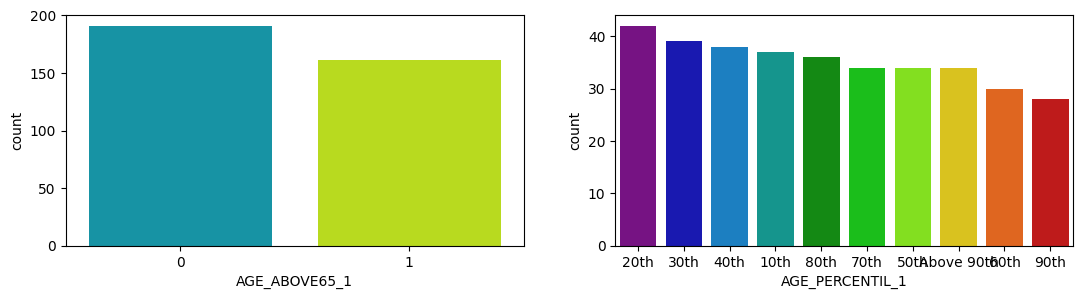

In [ ]:
#AGE_ABOVE65 and AGE_PERCENTIL
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 3))
sns.countplot(x= data['AGE_ABOVE65_1'], ax = axis[0],palette='nipy_spectral')
sns.countplot(x=  data['AGE_PERCENTIL_1'], ax = axis[1],palette='nipy_spectral')
plt.show(fig)

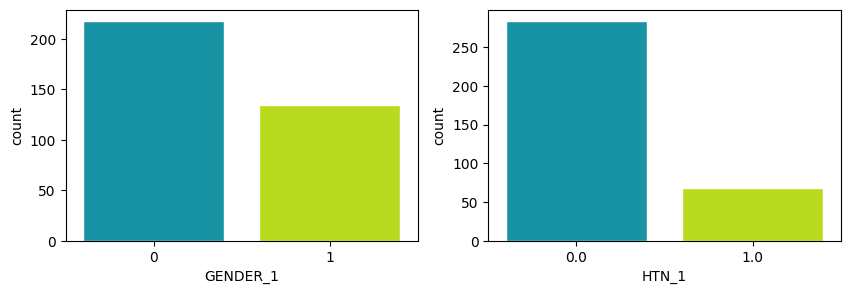

In [ ]:
# GENDER and HTN
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))
sns.set_style('white')
sns.countplot(x = data['GENDER_1'], ax = axis[0], palette='nipy_spectral' )
sns.countplot(x = data['HTN_1'], ax = axis[1], palette='nipy_spectral' )
plt.show(fig)

In [ ]:
def normalized_stacked_bars(data, col, target):
    plt.figure(figsize=(7, 5))  # Adjust figure size

    bottom = [0 for _ in data[col].unique()]
    color_palette = sns.color_palette("Set2", len(data[target].unique()))  # Choose a seaborn color palette

    for cls, color in zip(data[target].unique(), color_palette):
        x_vals, y_vals = np.unique(data[data[target] == cls][col], return_counts=True)
        x_vals = [str(x) for x in x_vals]
        y_vals = [x / y for x, y in zip(y_vals, np.unique(data[col], return_counts=True)[1])]

        plt.bar(x_vals, y_vals, bottom=bottom, color=color, label=cls, alpha=0.7)  # Add alpha for transparency
        bottom = [x + y for x, y in zip(bottom, y_vals)]

    plt.legend(title=target, loc='upper right')
    plt.title(f'Normalized Stacked Bars - {col}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

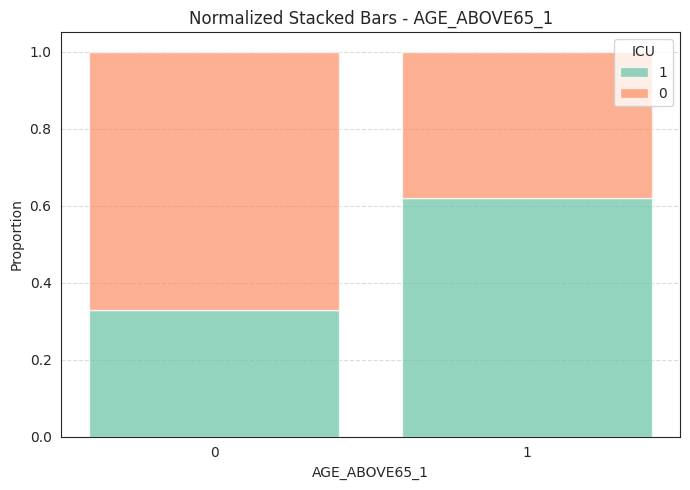

In [ ]:
#AGE_ABOVE65
normalized_stacked_bars(data, 'AGE_ABOVE65_1', 'ICU')

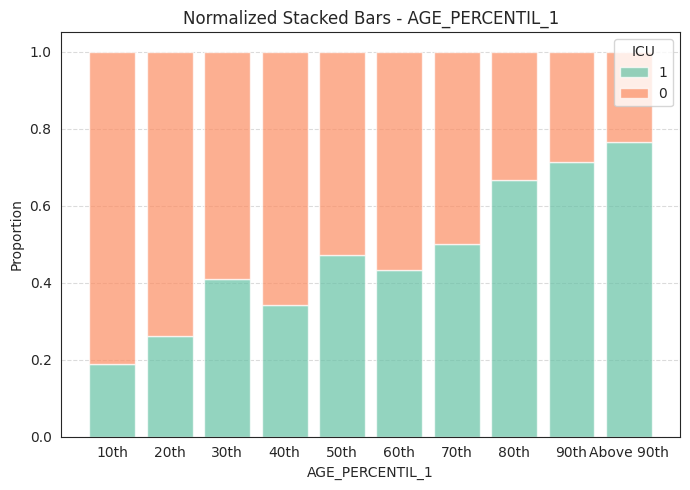

In [ ]:
#AGE_PERCENTIL
normalized_stacked_bars(data, 'AGE_PERCENTIL_1', 'ICU')

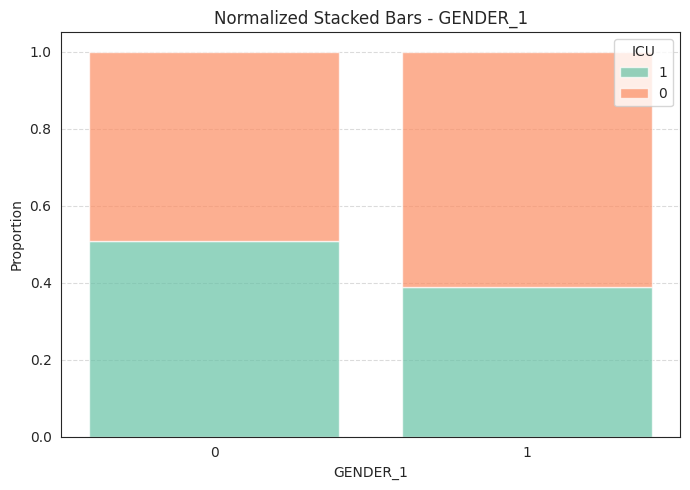

In [ ]:
#GENDER
normalized_stacked_bars(data, 'GENDER_1', 'ICU')

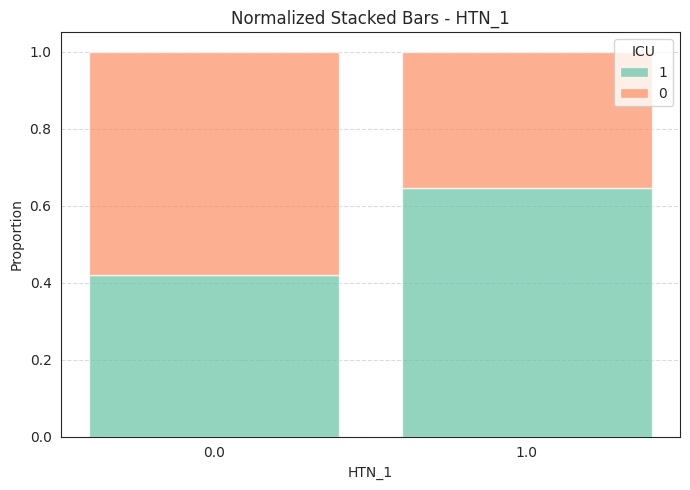

In [ ]:
#HTN
normalized_stacked_bars(data, 'HTN_1', 'ICU')

**3.2. Time-Variant Features**

In [ ]:
#Identifying time variant features and groups of features
patient_constant_cols = [x + '_1' for x in patient_constant_cols]

time_variant_cols = [x for x in data.columns.values if x not in patient_constant_cols]
time_variant_cols.remove('PATIENT_VISIT_IDENTIFIER_1')
time_variant_cols.remove('ICU')

time_variant_groups = np.unique([x[:-2] for x in time_variant_cols])
print(time_variant_groups)

['BLOODPRESSURE_DIASTOLIC_DIFF' 'BLOODPRESSURE_DIASTOLIC_DIFF_REL'
 'BLOODPRESSURE_DIASTOLIC_MAX' 'BLOODPRESSURE_DIASTOLIC_MEAN'
 'BLOODPRESSURE_DIASTOLIC_MEDIAN' 'BLOODPRESSURE_DIASTOLIC_MIN'
 'BLOODPRESSURE_SISTOLIC_DIFF' 'BLOODPRESSURE_SISTOLIC_DIFF_REL'
 'BLOODPRESSURE_SISTOLIC_MAX' 'BLOODPRESSURE_SISTOLIC_MEAN'
 'BLOODPRESSURE_SISTOLIC_MEDIAN' 'BLOODPRESSURE_SISTOLIC_MIN'
 'DISEASE GROUPING 1' 'DISEASE GROUPING 2' 'DISEASE GROUPING 3'
 'DISEASE GROUPING 4' 'DISEASE GROUPING 5' 'DISEASE GROUPING 6'
 'HEART_RATE_DIFF' 'HEART_RATE_DIFF_REL' 'HEART_RATE_MAX'
 'HEART_RATE_MEAN' 'HEART_RATE_MEDIAN' 'HEART_RATE_MIN'
 'IMMUNOCOMPROMISED' 'OTHER' 'OXYGEN_SATURATION_DIFF'
 'OXYGEN_SATURATION_DIFF_REL' 'OXYGEN_SATURATION_MAX'
 'OXYGEN_SATURATION_MEAN' 'OXYGEN_SATURATION_MEDIAN'
 'OXYGEN_SATURATION_MIN' 'RESPIRATORY_RATE_DIFF'
 'RESPIRATORY_RATE_DIFF_REL' 'RESPIRATORY_RATE_MAX'
 'RESPIRATORY_RATE_MEAN' 'RESPIRATORY_RATE_MEDIAN' 'RESPIRATORY_RATE_MIN'
 'TEMPERATURE_DIFF' 'TEMPERATURE_DIFF_REL'

**3.2.1. First Approach: Investigate Entire Feature Groups**

In [ ]:
#Identify the largers clusters
not_cluster_friendly = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
                        'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
                        'IMMUNOCOMPROMISED', 'OTHER']

clusters = np.unique([x.split('_')[-1] for x in time_variant_groups if x not in not_cluster_friendly])
print(clusters)

['DIFF' 'MAX' 'MEAN' 'MEDIAN' 'MIN' 'REL']


In [ ]:
#Define function to compile all values from a feature group
def extract_values_from_group(data, group_name):
    group_cols = [x for x in data.columns.values if x[:-2] == group_name]
    return data[group_cols].values.reshape(-1)

In [ ]:
#Define function to plot all feature groups from a cluster
def plot_by_cluster(data, col_groups, cluster_name):
    #Identify groups to be ploted
    groups = [x for x in col_groups if x[-len(cluster_name):] == cluster_name]

    #Compute dimensions for subplots
    ncols = 2
    nrows = int(len(groups) / 2) if len(groups) % 2 == 0 else np.floor(len(groups) / 2) + 1

    #Plot groups
    fig, axis = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 3*nrows))
    for i, group in enumerate(groups):
        row = int(i / 2)
        col = 0 if i%2 == 0 else 1
        if data[group + '_1'].dtype == np.int64:
            sns.countplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
        else:
            sns.distplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)

    fig.tight_layout()
    return plt.show()

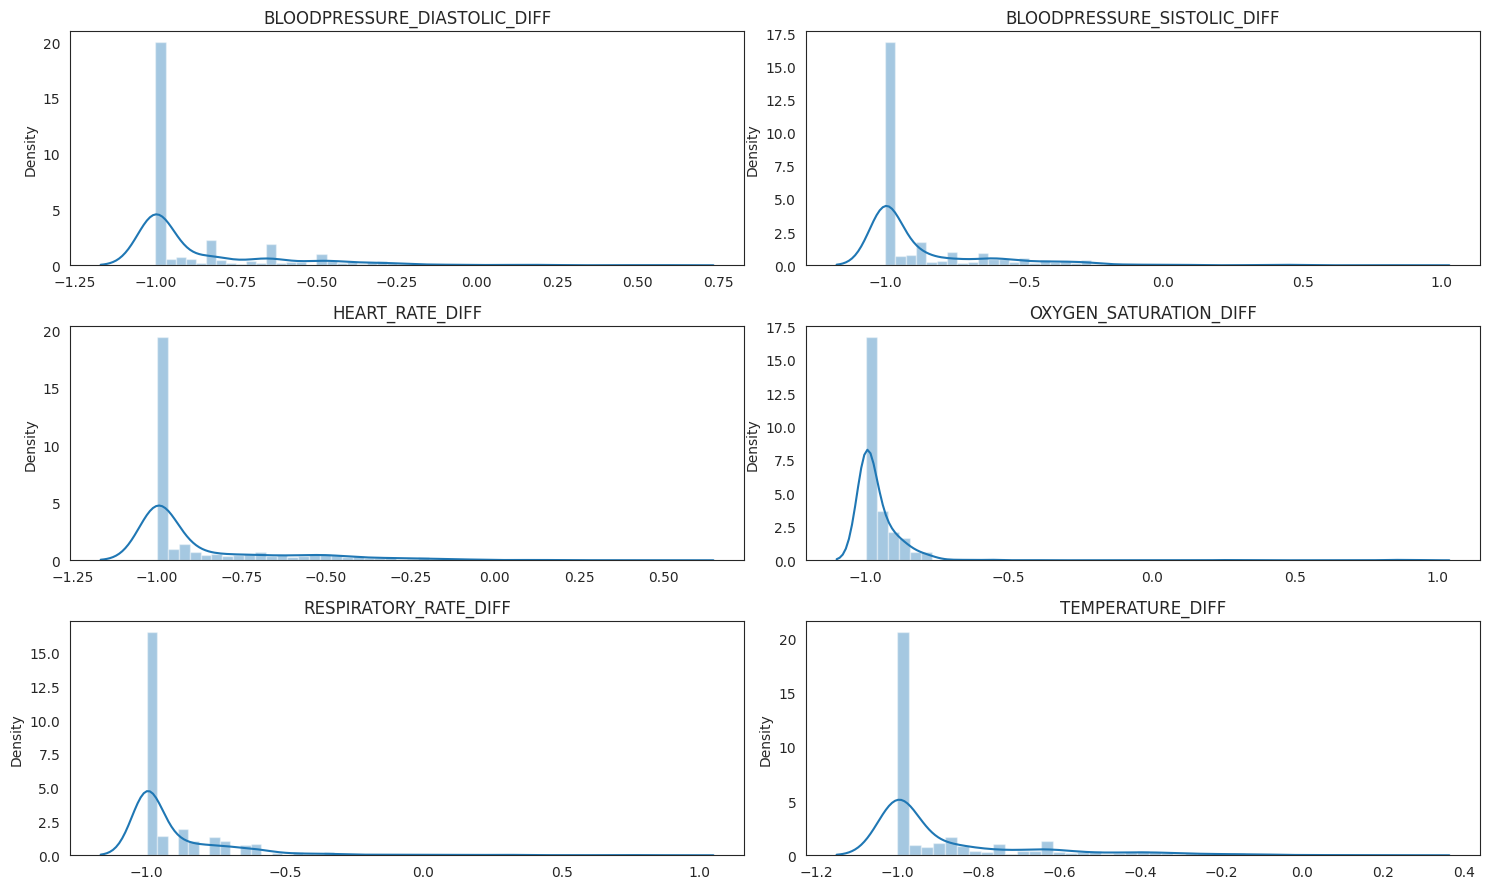

In [ ]:
#DIFF
plot_by_cluster(data, time_variant_groups, 'DIFF')

Observation
1. Feature groups within the DIFF cluster exhibit highly similar behavior.
2. Most values are close to -1 across the board.

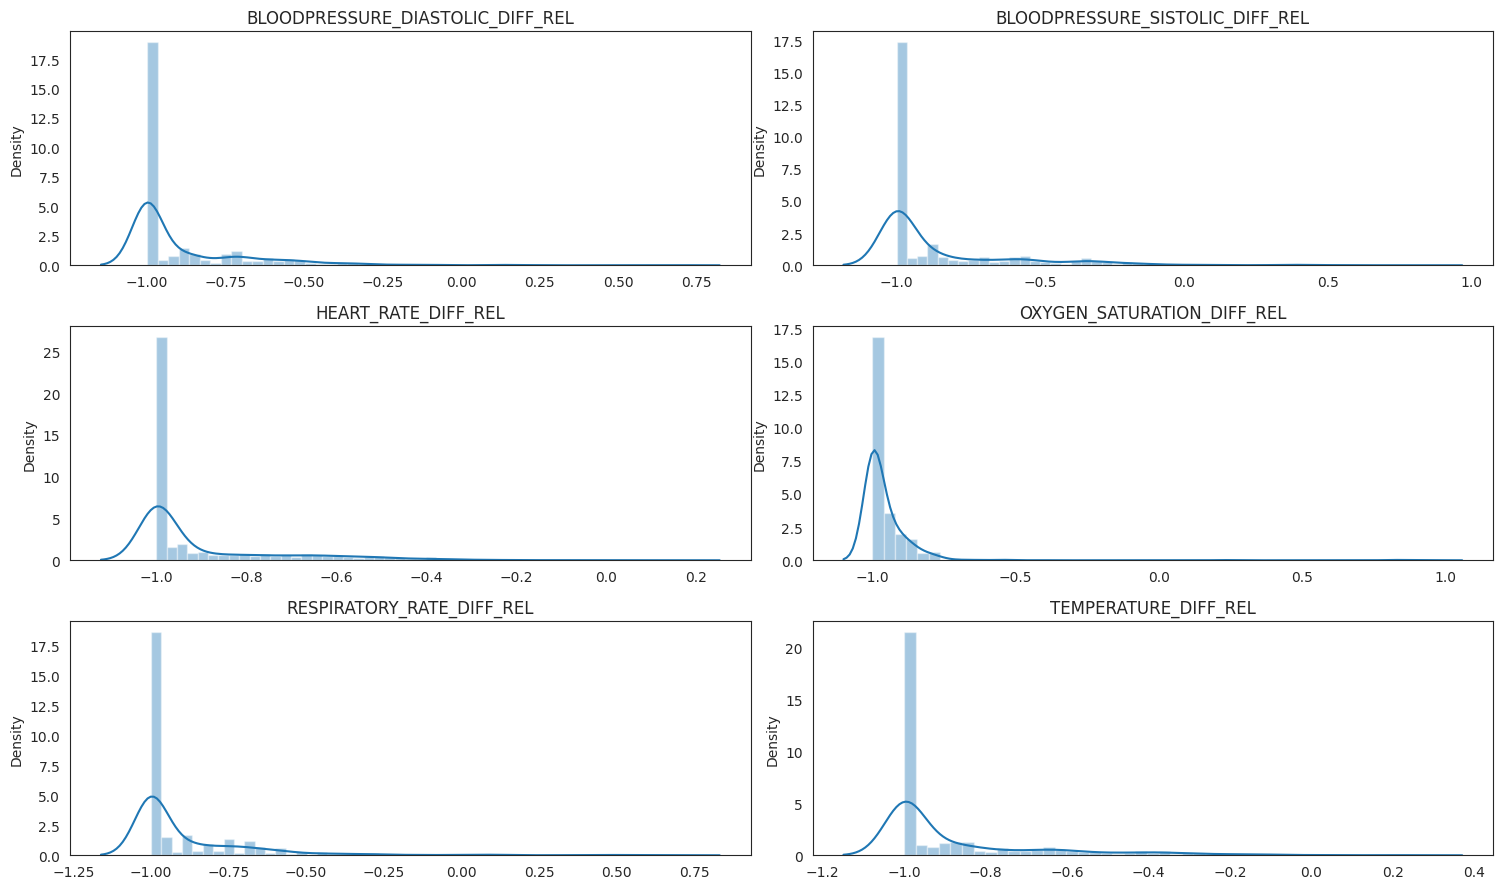

In [ ]:
#REL
plot_by_cluster(data, time_variant_groups, 'DIFF_REL')

In [ ]:
#Identify remaining groups for plotting
reduced_time_variant_groups = \
[x for x in time_variant_groups if ('DIFF' not in x and x not in not_cluster_friendly)]

new_clusters = np.unique(['_'.join(x.split('_')[:-1]) for x in reduced_time_variant_groups])
new_clusters

array(['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE',
       'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE'],
      dtype='<U23')

In [ ]:
#Redefine function to plot all feature groups from a cluster
def plot_by_cluster(data, col_groups, cluster_name):
    # Identify groups to be plotted
    groups = [x for x in col_groups if x[:len(cluster_name)] == cluster_name]

    # Compute dimensions for subplots
    ncols = 2
    nrows = int(np.ceil(len(groups) / 2))  # Use ceil to handle odd number of groups

    # Plot groups
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

    for i, group in enumerate(groups):
        row = i // ncols
        col = i % ncols

        ax = axes[row, col] if nrows > 1 else axes[col]

        if data[group + '_1'].dtype == np.int64:
            sns.countplot(x=group + '_1', data=data, ax=ax, palette="viridis")
            ax.set_title(group)
        else:
            sns.histplot(x=group + '_1', data=data, ax=ax, kde=True, color="skyblue")
            ax.set_title(group)

    fig.tight_layout()
    plt.show()

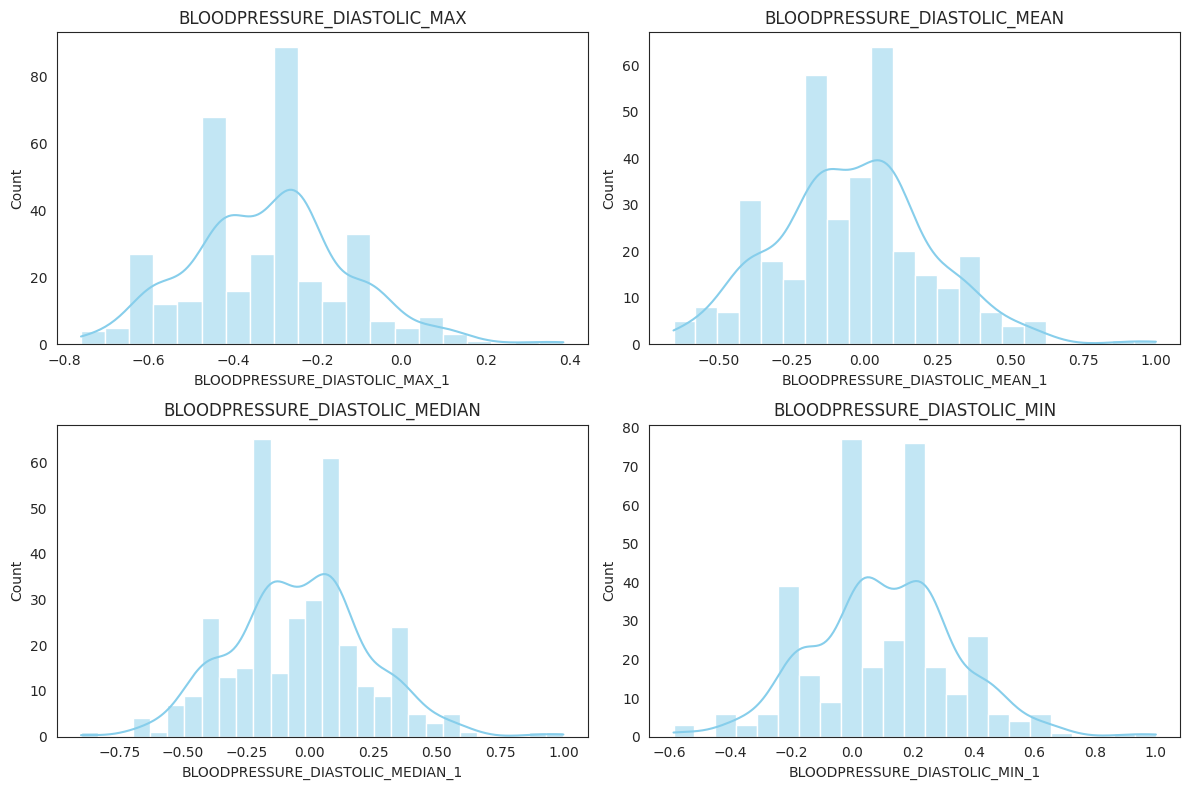

In [ ]:
#BLOODPRESSURE_DIASTOLIC'
plot_by_cluster(data, reduced_time_variant_groups, 'BLOODPRESSURE_DIASTOLIC')

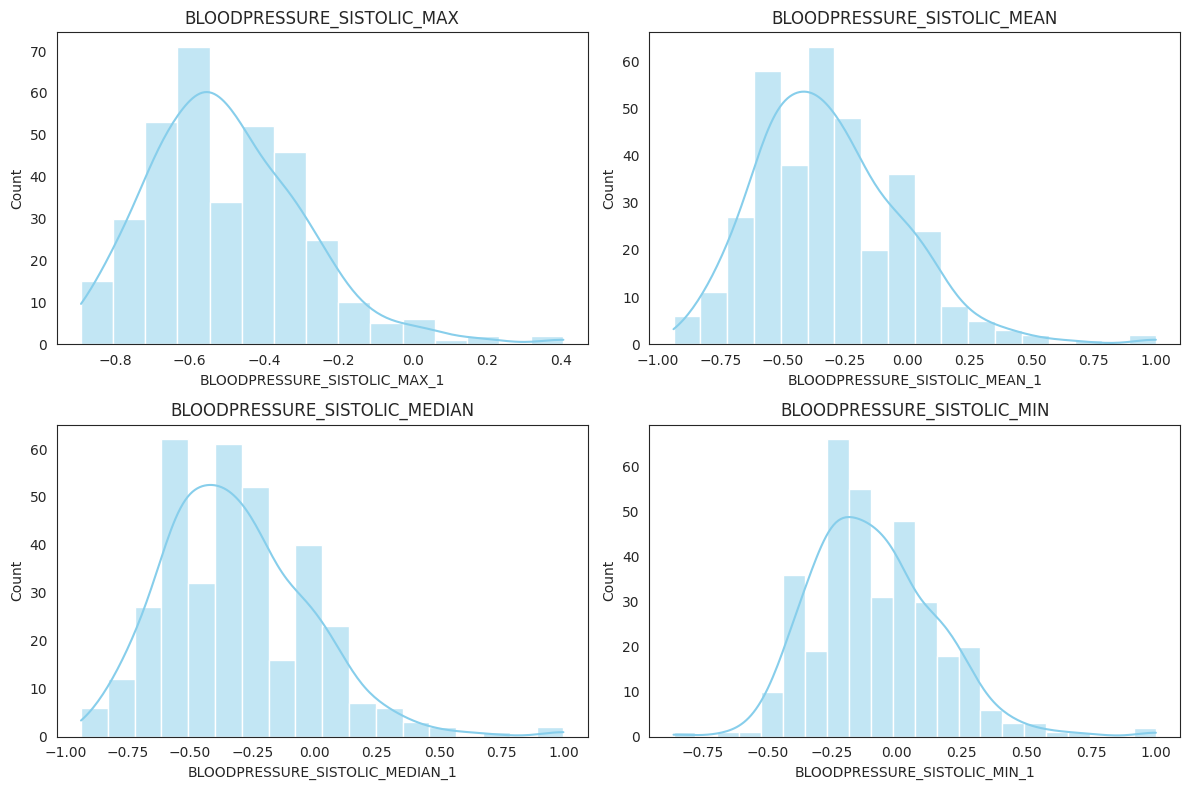

In [ ]:
#BLOODPRESSURE_SISTOLIC
plot_by_cluster(data, reduced_time_variant_groups, 'BLOODPRESSURE_SISTOLIC')

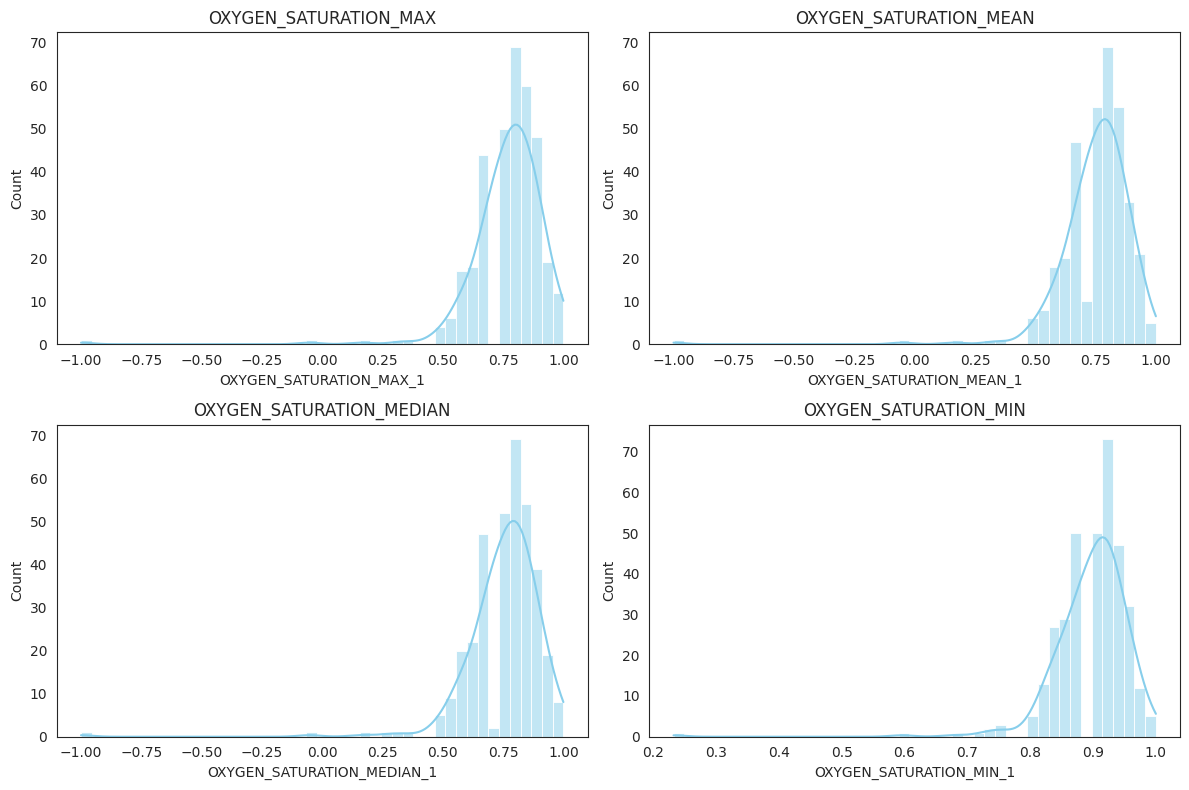

In [ ]:
#OXYGEN_SATURATION
plot_by_cluster(data, reduced_time_variant_groups, 'OXYGEN_SATURATION')

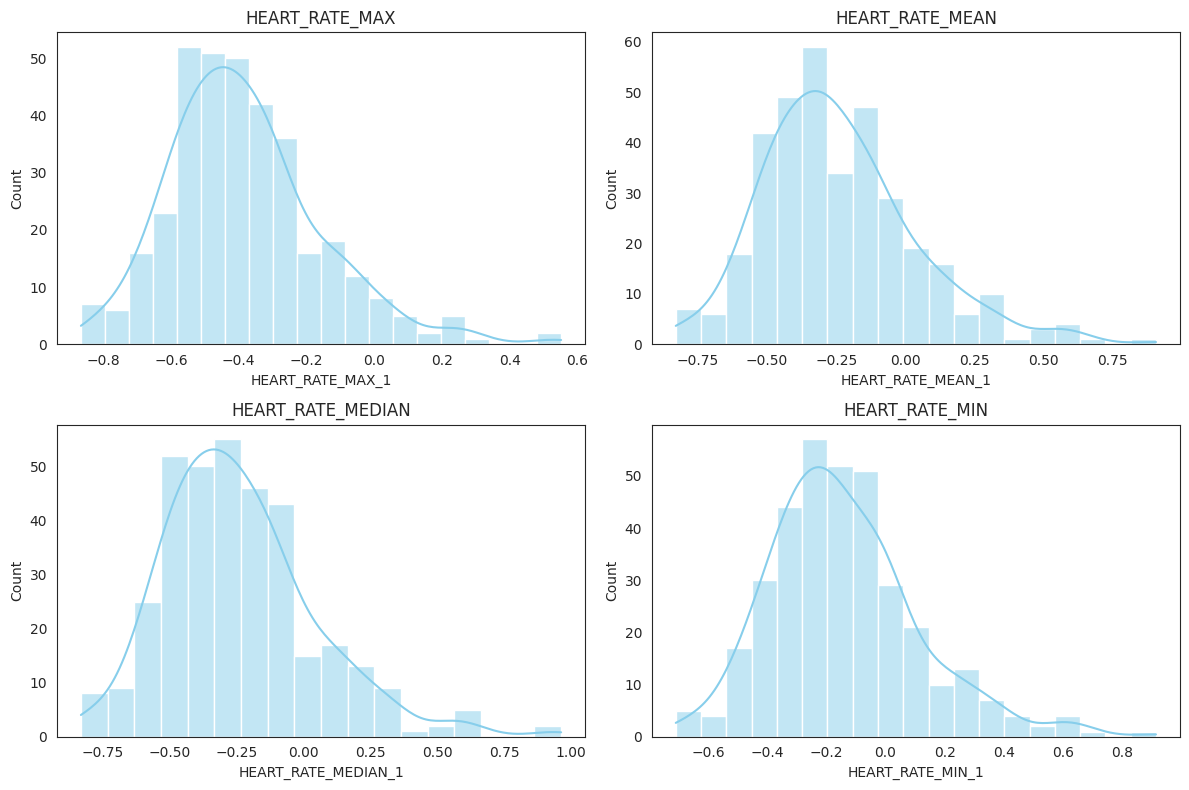

In [ ]:
#HEART_RATE
plot_by_cluster(data, reduced_time_variant_groups, 'HEART_RATE')

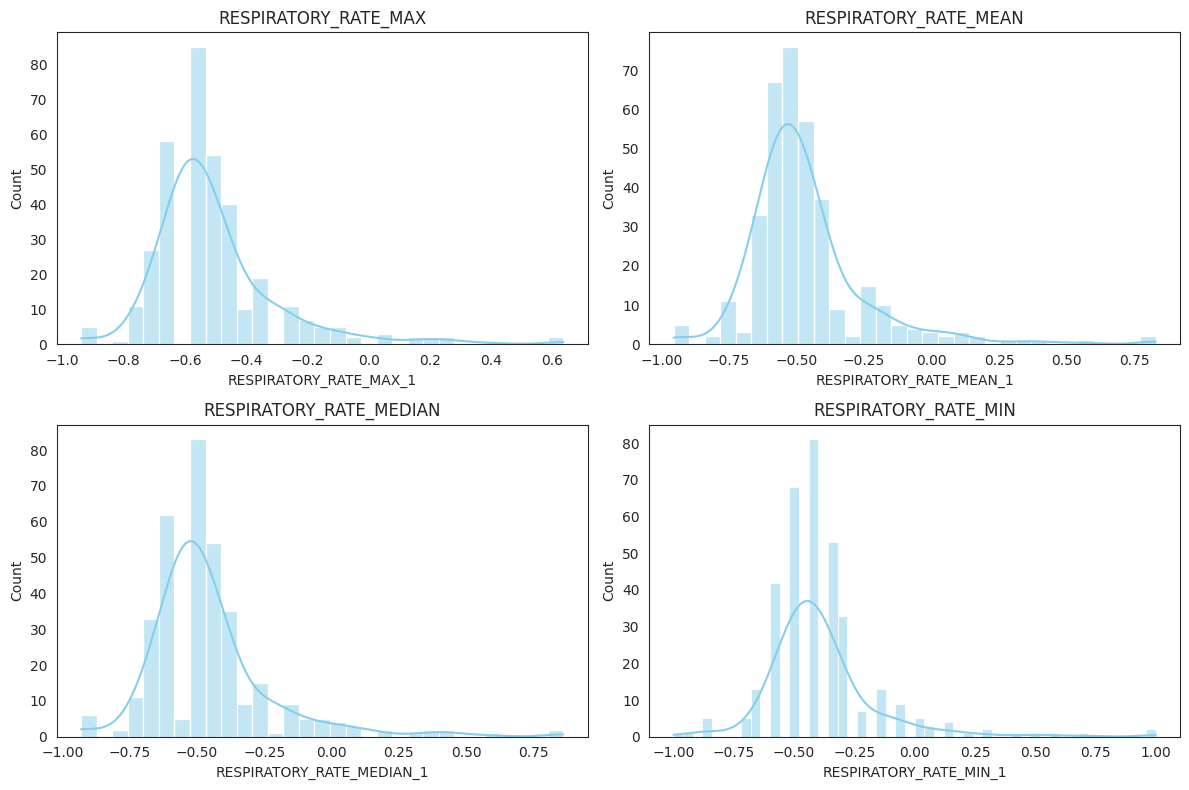

In [ ]:
#RESPIRATORY_RATE
plot_by_cluster(data, reduced_time_variant_groups, 'RESPIRATORY_RATE')

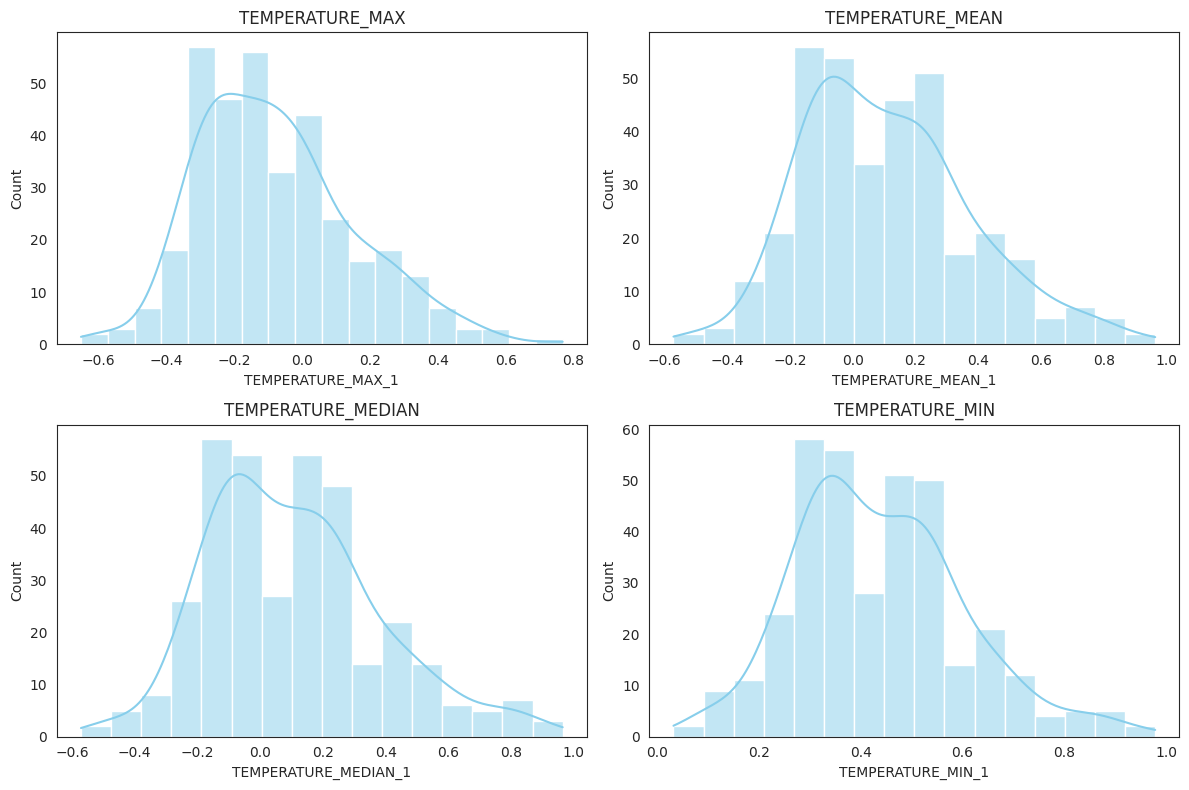

In [ ]:
#TEMPERATURE
plot_by_cluster(data, reduced_time_variant_groups, 'TEMPERATURE')

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813,0


# **Model 1: Window-1 Data Only**

In [ ]:
#Remove all data take after window 1
model_1_cols = [x for x in data.columns if x[-1] not in [str(y) for y in range(2,6)]]
data_1 = data[model_1_cols]

data_1.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_1,RESPIRATORY_RATE_MEDIAN_1,RESPIRATORY_RATE_MIN_1,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,TEMPERATURE_MAX_1,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,TEMPERATURE_MIN_1,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,-0.593220,-0.586207,-0.500000,-1.000000,-1.000000,-0.420290,-0.285714,-0.285714,0.208791,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,-0.645951,-0.517241,-0.714286,-1.000000,-1.000000,0.101449,0.357143,0.357143,0.604396,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.457627,-0.448276,-0.357143,-1.000000,-1.000000,-0.420290,-0.285714,-0.285714,0.208791,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.593220,-0.586207,-0.571429,-0.952381,-0.953536,0.072464,0.285714,0.285714,0.538462,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.525424,-0.517241,-0.428571,-0.976190,-0.975891,-0.333333,-0.196429,-0.196429,0.252747,0


**Model 1: Correlations**

<Figure size 1000x800 with 0 Axes>

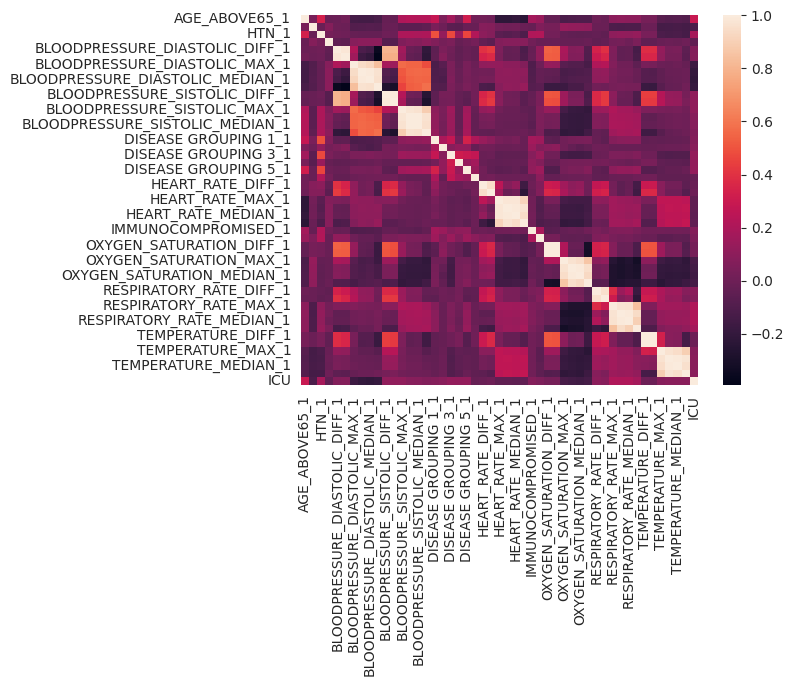

<Figure size 1000x800 with 0 Axes>

In [ ]:
#Compute Pearson correlation
data_1_corr = data_1.corr()

sns.heatmap(data_1_corr)
plt.figure(figsize = (10, 8))

In [ ]:
# Show correlation values in stacked format
def rank_correlation_score(data):

    #Stack correlation map into 3-columns format
    stacked_corr = data.corr().stack().reset_index().rename(
       columns = {'level_0': 'Feature_1',
                  'level_1': 'Feature_2',
                  0: 'Pearson_Corr'})

    #Remove redudant relationships
    stacked_corr = stacked_corr.query('Feature_1 != Feature_2')
    chained_feature_names = ['-'.join(np.sort(x)) for x in stacked_corr[['Feature_1', 'Feature_2']].values]
    stacked_corr.loc[:,'Duplicate_Key'] = chained_feature_names
    stacked_corr = stacked_corr.drop_duplicates(subset = 'Duplicate_Key').drop(columns = 'Duplicate_Key')

    #Remove correlations to the target
    stacked_corr = stacked_corr[stacked_corr['Feature_1'] != 'ICU']
    stacked_corr = stacked_corr[stacked_corr['Feature_2'] != 'ICU']

    # Order absolute correlation strenght
    stacked_corr['Pearson_Corr'] = abs(stacked_corr['Pearson_Corr'])
    return stacked_corr.sort_values(by = 'Pearson_Corr', ascending = False)

stacked_data_1_corr = rank_correlation_score(data_1)
stacked_data_1_corr

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
...,...,...,...
733,BLOODPRESSURE_SISTOLIC_MEDIAN_1,TEMPERATURE_MIN_1,0.000809
924,DISEASE GROUPING 3_1,TEMPERATURE_DIFF_1,0.000746
516,BLOODPRESSURE_SISTOLIC_DIFF_1,HEART_RATE_MEDIAN_1,0.000576
194,PATIENT_VISIT_IDENTIFIER_1,TEMPERATURE_MIN_1,0.000536


In [ ]:
#Filter very strong correlations
stacked_data_1_corr[stacked_data_1_corr['Pearson_Corr'] > 0.99]

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
351,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,0.992260
1651,OXYGEN_SATURATION_MEAN_1,OXYGEN_SATURATION_MEDIAN_1,0.990731
501,BLOODPRESSURE_SISTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.990595


In [ ]:
#Investigate MEAN/MEDIAN correlations
stacked_data_1_corr['MEASURE_FEATURE_1'] = [x.split('_')[0] for x in stacked_data_1_corr['Feature_1']]
stacked_data_1_corr['MEASURE_FEATURE_2'] = [x.split('_')[0] for x in stacked_data_1_corr['Feature_2']]
stacked_data_1_corr['TYPE_FEATURE_1'] = [x.split('_')[-2] for x in stacked_data_1_corr['Feature_1']]
stacked_data_1_corr['TYPE_FEATURE_2'] = [x.split('_')[-2] for x in stacked_data_1_corr['Feature_2']]

mean_median_corr = stacked_data_1_corr.query('MEASURE_FEATURE_1 == MEASURE_FEATURE_2')
mean_median_corr = mean_median_corr.query('TYPE_FEATURE_1 != TYPE_FEATURE_2')
mean_median_corr = mean_median_corr[mean_median_corr['TYPE_FEATURE_1'].isin(['MEDIAN', 'MEAN'])]
mean_median_corr = mean_median_corr[mean_median_corr['TYPE_FEATURE_2'].isin(['MEDIAN', 'MEAN'])]

relevant_cols = ['Feature_1', 'Feature_2', 'Pearson_Corr']
mean_median_corr[relevant_cols]

,Feature_1,Feature_2,Pearson_Corr
651,BLOODPRESSURE_SISTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.996952
1251,HEART_RATE_MEAN_1,HEART_RATE_MEDIAN_1,0.993374
2251,TEMPERATURE_MEAN_1,TEMPERATURE_MEDIAN_1,0.993236
351,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,0.992260
1651,OXYGEN_SATURATION_MEAN_1,OXYGEN_SATURATION_MEDIAN_1,0.990731
1951,RESPIRATORY_RATE_MEAN_1,RESPIRATORY_RATE_MEDIAN_1,0.989124
357,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_SISTOLIC_MEDIAN_1,0.560540
405,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,BLOODPRESSURE_SISTOLIC_MEAN_1,0.539823


In [ ]:
#List columns to be removed
cols_to_remove = ['BLOODPRESSURE_DIASTOLIC_MEDIAN_1', 'BLOODPRESSURE_SISTOLIC_MEDIAN_1', 'HEART_RATE_MEDIAN_1',
                  'OXYGEN_SATURATION_MEDIAN_1', 'RESPIRATORY_RATE_MEDIAN_1', 'TEMPERATURE_MEDIAN_1']

In [ ]:
#Investigate DIFF/DIFF_REL correlations
diff_corr = stacked_data_1_corr.query('MEASURE_FEATURE_1 == MEASURE_FEATURE_2')
diff_corr = diff_corr.query('TYPE_FEATURE_1 != TYPE_FEATURE_2')
diff_corr = diff_corr[diff_corr['TYPE_FEATURE_1'].isin(['DIFF', 'REL'])]
diff_corr = diff_corr[diff_corr['TYPE_FEATURE_2'].isin(['DIFF', 'REL'])]

diff_corr[relevant_cols]

,Feature_1,Feature_2,Pearson_Corr
2101,TEMPERATURE_DIFF_1,TEMPERATURE_DIFF_REL_1,0.999444
1501,OXYGEN_SATURATION_DIFF_1,OXYGEN_SATURATION_DIFF_REL_1,0.998889
501,BLOODPRESSURE_SISTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.990595
201,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,0.978508
1801,RESPIRATORY_RATE_DIFF_1,RESPIRATORY_RATE_DIFF_REL_1,0.961739
1101,HEART_RATE_DIFF_1,HEART_RATE_DIFF_REL_1,0.949914
207,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_DIFF_REL_1,0.799433
255,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_SISTOLIC_DIFF_1,0.777548


In [ ]:
#Add columns to the remove list
cols_to_remove.extend(['BLOODPRESSURE_DIASTOLIC_DIFF_REL_1', 'BLOODPRESSURE_SISTOLIC_DIFF_REL_1',
                       'HEART_RATE_DIFF_REL_1', 'OXYGEN_SATURATION_DIFF_REL_1', 'RESPIRATORY_RATE_DIFF_REL_1',
                       'TEMPERATURE_DIFF_REL_1'])

In [ ]:
#Sort absolute correlations values to the target
data_1 = data_1.drop(columns = cols_to_remove)
data_1_target_corr = abs(data_1.corr()['ICU'])

data_1_target_corr[data_1_target_corr < 1].sort_values(ascending = False)

AGE_ABOVE65_1                     0.291010
RESPIRATORY_RATE_MAX_1            0.213938
RESPIRATORY_RATE_MEAN_1           0.207911
BLOODPRESSURE_DIASTOLIC_MEAN_1    0.201210
BLOODPRESSURE_DIASTOLIC_MIN_1     0.195703
HTN_1                             0.180555
RESPIRATORY_RATE_MIN_1            0.173043
BLOODPRESSURE_DIASTOLIC_MAX_1     0.166832
OXYGEN_SATURATION_MEAN_1          0.147612
OXYGEN_SATURATION_MIN_1           0.139034
OXYGEN_SATURATION_MAX_1           0.131615
DISEASE GROUPING 3_1              0.122514
DISEASE GROUPING 5_1              0.122200
GENDER_1                          0.117938
DISEASE GROUPING 4_1              0.112573
BLOODPRESSURE_SISTOLIC_MAX_1      0.109073
BLOODPRESSURE_SISTOLIC_DIFF_1     0.107106
RESPIRATORY_RATE_DIFF_1           0.093877
DISEASE GROUPING 2_1              0.087753
TEMPERATURE_MEAN_1                0.086764
TEMPERATURE_MIN_1                 0.086575
BLOODPRESSURE_SISTOLIC_MEAN_1     0.084371
TEMPERATURE_MAX_1                 0.079548
DISEASE GRO

 **Model 1: Feature Encoding**

In [ ]:
#Define function to encode features
def encode_feature(data, col):
    new_cols = pd.get_dummies(data[col], prefix = col, prefix_sep = ':', drop_first = True)
    return pd.concat([data.drop(columns = col), new_cols], axis = 1)

In [ ]:
data_1 = encode_feature(data_1, 'AGE_PERCENTIL_1')

In [ ]:
data_1

,AGE_ABOVE65_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MIN_1,BLOODPRESSURE_SISTOLIC_DIFF_1,BLOODPRESSURE_SISTOLIC_MAX_1,...,ICU,AGE_PERCENTIL_1:30th,AGE_PERCENTIL_1:40th,AGE_PERCENTIL_1:10th,AGE_PERCENTIL_1:80th,AGE_PERCENTIL_1:70th,AGE_PERCENTIL_1:50th,AGE_PERCENTIL_1:Above 90th,AGE_PERCENTIL_1:60th,AGE_PERCENTIL_1:90th
0,1,0,0.0,0,-1.000000,-0.247863,0.086420,0.237113,-1.000000,-0.459459,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0.0,2,-0.547826,-0.435897,-0.489712,-0.525773,-0.533742,-0.491892,...,1,0,0,1,0,0,0,0,0,0
3,0,1,0.0,3,-1.000000,-0.299145,0.012346,0.175258,-1.000000,-0.556757,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0.0,4,-1.000000,-0.076923,0.333333,0.443299,-0.877301,-0.351351,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0.0,5,-0.826087,-0.247863,-0.037037,0.030928,-0.754601,-0.567568,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,1,0.0,380,-1.000000,-0.418803,-0.160494,0.030928,-1.000000,-0.783784,...,1,0,1,0,0,0,0,0,0,0
381,1,0,0.0,381,-1.000000,-0.589744,-0.407407,-0.175258,-1.000000,-0.783784,...,0,0,0,0,0,0,0,1,0,0
382,0,0,0.0,382,-1.000000,-0.299145,0.012346,0.175258,-1.000000,-0.567568,...,1,0,0,0,0,0,1,0,0,0
383,0,1,0.0,383,-1.000000,-0.247863,0.086420,0.237113,-1.000000,-0.459459,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
#Split data into train/test and validation
np.random.seed(10)

target_col = 'ICU'
feature_cols = data_1.drop(columns = ['ICU', 'PATIENT_VISIT_IDENTIFIER_1']).columns.values

x_train, x_validation, y_train, y_validation = train_test_split(data_1[feature_cols], data_1[target_col],
                                                                test_size = 0.1)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def score_model(estimator, train_data, validation_data, cv):
    # Unpack data
    x_train, y_train = train_data
    x_validation, y_validation = validation_data

    # Perform cross-validation on train data
    model_cv = cross_validate(estimator=estimator, X=x_train, y=y_train,
                              scoring=['accuracy', 'roc_auc'],
                              cv=cv)

    # Apply model to validation data
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_validation)

    # Print results
    print('CV model accuracy: %.3f +/- %.3f' % (model_cv['test_accuracy'].mean(),
                                                model_cv['test_accuracy'].std()))
    print('CV model roc_auc: %.3f +/- %.3f' % (model_cv['test_roc_auc'].mean(),
                                               model_cv['test_roc_auc'].std()))
    print('Validation accuracy score: %.3f' % accuracy_score(y_validation, y_pred))
    print('Validation ROC_AUC score: %.3f' % roc_auc_score(y_validation, y_pred))

    # Compute ROC curve and area under the curve
    fpr, tpr, _ = roc_curve(y_validation, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_validation, y_pred)
    sns.heatmap(cm,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

    return estimator

CV model accuracy: 0.661 +/- 0.079
CV model roc_auc: 0.716 +/- 0.069
Validation accuracy score: 0.722
Validation ROC_AUC score: 0.700


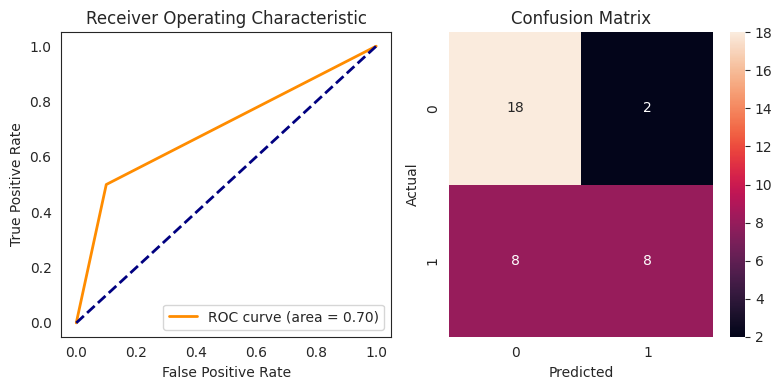

In [ ]:
# Test Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(random_state=10)
logistic_model = score_model(logistic_model, (x_train, y_train), (x_validation, y_validation), cv=5)

CV model accuracy: 0.668 +/- 0.052
CV model roc_auc: 0.718 +/- 0.067
Validation accuracy score: 0.611
Validation ROC_AUC score: 0.588


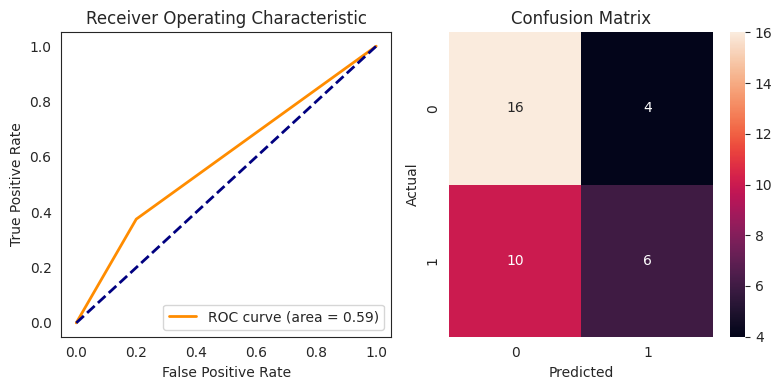

In [ ]:
from sklearn import svm
# Test SVM
svm_estimator = svm.SVC(kernel='linear', C=1)

# Call the score_model function
trained_svm = score_model(svm_estimator, (x_train, y_train), (x_validation, y_validation), cv=5)

CV model accuracy: 0.670 +/- 0.101
CV model roc_auc: 0.728 +/- 0.084
Validation accuracy score: 0.778
Validation ROC_AUC score: 0.769


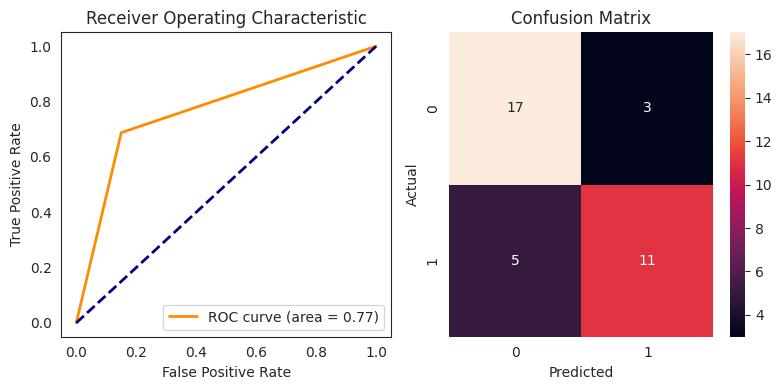

In [ ]:
# Test RandomForestClassifier model
randomForest_model = RandomForestClassifier()
randomForest_model = score_model(estimator = randomForest_model,
                                      train_data = (x_train, y_train),
                                      validation_data = (x_validation, y_validation),
                                      cv = 10)

1.   Further investigate the dataset in order to remove or add features.
2. Tune the algorithm hyperparameters to see if we can achieve some accuracy improvemen.
3. Discard this approach and proceed to a time-relevant model.



<Axes: >

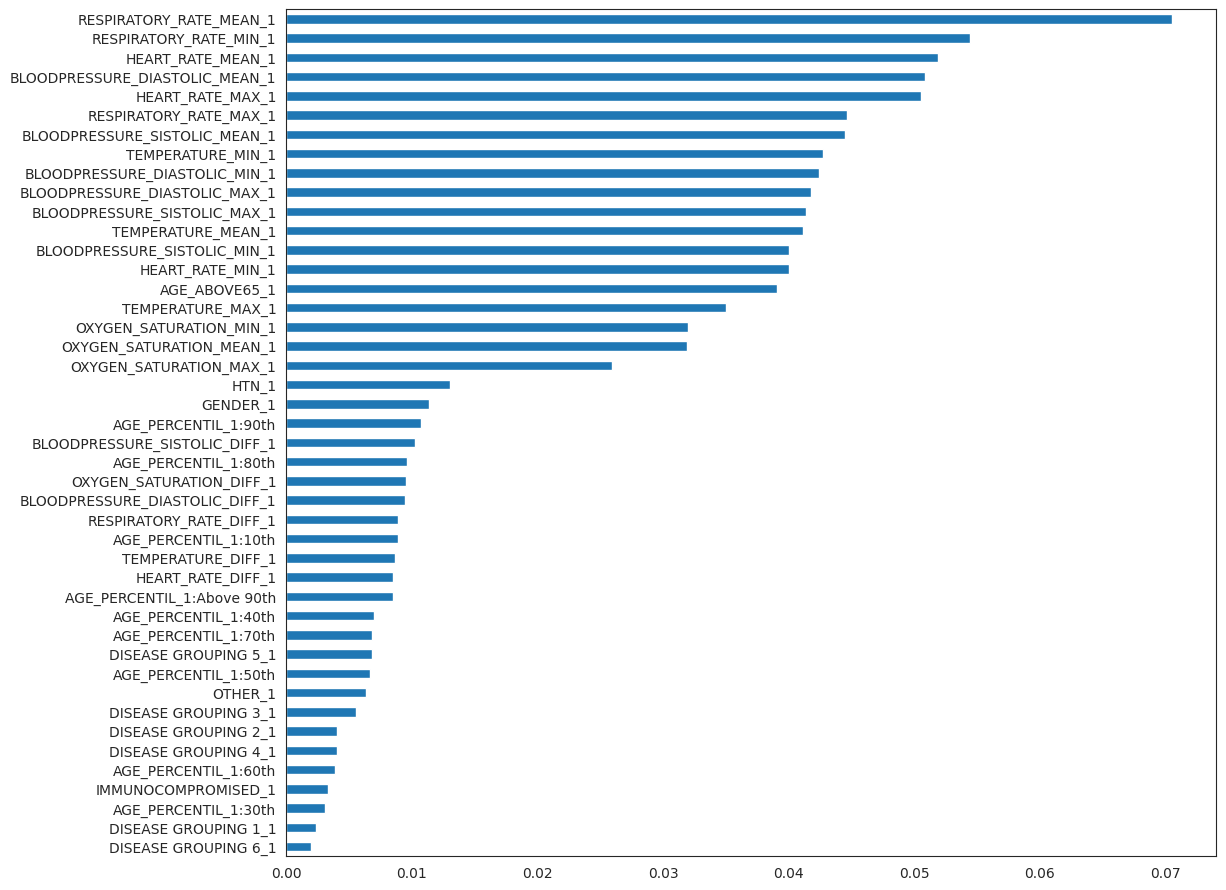

In [ ]:
#Plot feature importances for the Random Forest Model
feat_importances = pd.Series(data = randomForest_model.feature_importances_,
                             index = feature_cols).sort_values()
feat_importances.plot(kind = 'barh', figsize = (12, 11))


The graph indicates two key observations:

1. RESPIRATORY_RATE_MEAN_1 is the most
crucial feature in the classification model.
2. Following OXYGEN_SATURATION_MAX_1, there is a notable decline in attribute importance.

To validate this assessment, consider RFE feature ranking and evaluating the algorithm's performance.

In [ ]:
#Get RFE feature ranking and compare to RandomForestClassifier feature importance
rfe_model = RandomForestClassifier(n_estimators = 10)
feature_selector = RFE(estimator = rfe_model, step = 1)
feature_selector.fit(x_train, y_train)
feature_ranking = pd.Series(data = feature_selector.ranking_, index = feature_cols).sort_values()

importance_scale = pd.concat([feature_ranking, feat_importances.rank(ascending = False)], axis = 1)
importance_scale = importance_scale.rename(columns = {0: 'RFE_ranking', 1: 'RFC_ranking'})
importance_scale.sort_values(by = ['RFE_ranking', 'RFC_ranking'])

,RFE_ranking,RFC_ranking
RESPIRATORY_RATE_MEAN_1,1,1.0
RESPIRATORY_RATE_MIN_1,1,2.0
HEART_RATE_MEAN_1,1,3.0
BLOODPRESSURE_DIASTOLIC_MEAN_1,1,4.0
HEART_RATE_MAX_1,1,5.0
RESPIRATORY_RATE_MAX_1,1,6.0
BLOODPRESSURE_SISTOLIC_MEAN_1,1,7.0
TEMPERATURE_MIN_1,1,8.0
BLOODPRESSURE_DIASTOLIC_MIN_1,1,9.0
BLOODPRESSURE_DIASTOLIC_MAX_1,1,10.0


CV model accuracy: 0.655 +/- 0.087
CV model roc_auc: 0.723 +/- 0.099
Validation accuracy score: 0.722
Validation ROC_AUC score: 0.719


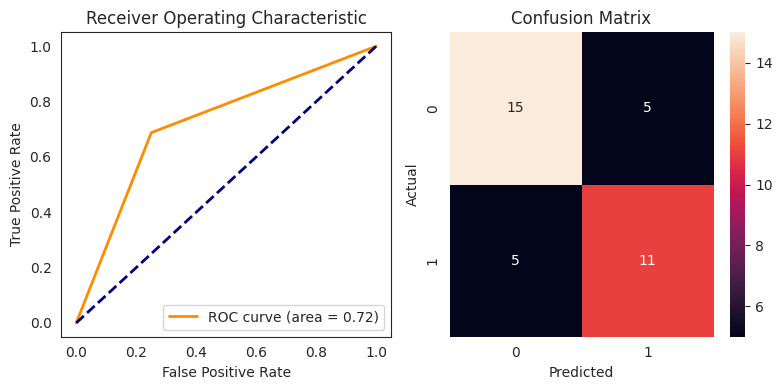

In [ ]:
#Test RandomForest model for RFE reduced dataset
cols_to_keep = importance_scale[importance_scale['RFE_ranking'] == 1].index
reduced_x_train = x_train[cols_to_keep]
reduced_x_validation = x_validation[cols_to_keep]

fitted_baseline_model_4 = score_model(estimator = randomForest_model,
                                      train_data = (reduced_x_train, y_train),
                                      validation_data = (reduced_x_validation, y_validation),
                                      cv = 10)

**Model 1: Hyperparameters Tuning**

In [ ]:
#Define hyperparameter space
hyper_space = {
    'n_estimators': [10, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
#Perform hyperparameter tuning by grid searching the defined space
grid_search = GridSearchCV(estimator = randomForest_model,
                           param_grid = hyper_space,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = 4,
                           verbose = 1)
grid_search_results = grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [ ]:
#Look at the best performing set of hyperparameters and apply estimator on validation data
print(grid_search.best_params_)

best_gridsearch_model = grid_search.best_estimator_
best_gridsearch_model.fit(x_train, y_train)
y_pred = best_gridsearch_model.predict(x_validation)

print('Validation accuracy: %.3f' %(accuracy_score(y_validation, y_pred)))
print('Validation ROC_AUC: %.3f' %(roc_auc_score(y_validation, y_pred)))

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Validation accuracy: 0.778
Validation ROC_AUC: 0.769


# **Model 2: Modelling Between 2 - 6 Hours**


In [ ]:
#Split features into time variant and time constant
features_df = pd.DataFrame(data = data.columns.values, columns = ['Feature_name'])
features_df['Feature_group'] = [x[:-2] for x in features_df['Feature_name']]

features_df = features_df.join(on = 'Feature_group',
                               other = features_df.groupby(by = 'Feature_group').count(),
                               how = 'inner',
                               rsuffix = '_count')

time_constant_features = features_df[features_df['Feature_name_count'] == 1]['Feature_name'].values
time_variant_features = [x for x in features_df['Feature_name'] if x not in time_constant_features]

time_constant_features = time_constant_features[time_constant_features != 'PATIENT_VISIT_IDENTIFIER_1']

In [ ]:
#Define function to retrieve the two most recent time windows data
def last_two_windows_data(data, cols, reference_col):

    #Remove all records where there's only window-1 data available
    reference_group = np.sort([x for x in cols if x[:-2] == reference_col[:-2]])
    temp_data = data[data[reference_group[1]].isnull() == False].drop(columns = 'PATIENT_VISIT_IDENTIFIER_1')

    #Identify last two windows for each records
    reference_df = temp_data[reference_group]
    last_window = [len(reference_group) - x for x in reference_df.isnull().sum(axis = 1)]
    last_window = [[x, y] for x, y in zip(reference_df.index, last_window)]

    df_list = []
    #Extract desired columns for each record
    for window in range(2,6):
        index_portion = [x[0] for x in last_window if x[1] == window]
        data_portion = temp_data[temp_data.index.isin(index_portion)]

        window_cols = [x for x in data_portion.columns if x[-1] in [str(window), str(window - 1)]]
        data_portion = data_portion[window_cols]

        new_col_names = {x: x[:-1] + 'end' if x[-1] == str(window) else x[:-1] + 'begin'
                         for x in data_portion.columns}

        df_list.append(data_portion.rename(columns = new_col_names))

    return pd.concat(df_list), last_window

In [ ]:
#Get time variant features for the last two available time windows
data_2, last_window = last_two_windows_data(data = data.drop(columns = time_constant_features),
                                            cols = time_variant_features,
                                            reference_col = 'TEMPERATURE_MAX_1')

data_2.head()

,BLOODPRESSURE_DIASTOLIC_DIFF_begin,BLOODPRESSURE_DIASTOLIC_DIFF_REL_begin,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_DIFF_begin,BLOODPRESSURE_SISTOLIC_DIFF_REL_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,...,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,RESPIRATORY_RATE_MEDIAN_end,RESPIRATORY_RATE_MIN_end,TEMPERATURE_DIFF_end,TEMPERATURE_DIFF_REL_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,TEMPERATURE_MIN_end
14,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.030928,-1.000000,-1.000000,-0.686486,-0.553846,...,-0.212121,-0.118644,-0.103448,0.000000,-1.0,-1.0,-0.362319,-0.214286,-0.214286,0.252747
18,-0.965217,-0.977316,-0.008547,0.399177,0.382716,0.484536,-0.865031,-0.876606,-0.351351,-0.133333,...,-0.151515,-0.186441,-0.034483,-0.357143,-1.0,-1.0,-0.043478,0.178571,0.178571,0.494505
24,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.664865,-0.523077,...,-0.636364,-0.593220,-0.586207,-0.500000,-1.0,-1.0,-0.014493,0.214286,0.214286,0.516484
29,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.729730,-0.615385,...,-0.575758,-0.525424,-0.517241,-0.428571,-1.0,-1.0,0.188406,0.464286,0.464286,0.670330
31,-1.000000,-1.000000,-0.572650,-0.382716,-0.382716,-0.154639,-1.000000,-1.000000,-0.729730,-0.615385,...,0.030303,0.152542,0.172414,0.285714,-1.0,-1.0,-0.275362,-0.107143,-0.107143,0.318681


In [ ]:
#Merge time variant and time constant features together
data_2 = data_2.join(other = data[time_constant_features], how = 'inner')
data_2.head()

,BLOODPRESSURE_DIASTOLIC_DIFF_begin,BLOODPRESSURE_DIASTOLIC_DIFF_REL_begin,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_DIFF_begin,BLOODPRESSURE_SISTOLIC_DIFF_REL_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,...,TEMPERATURE_DIFF_REL_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,TEMPERATURE_MIN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU
14,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.030928,-1.000000,-1.000000,-0.686486,-0.553846,...,-1.0,-0.362319,-0.214286,-0.214286,0.252747,1,60th,1,0.0,1
18,-0.965217,-0.977316,-0.008547,0.399177,0.382716,0.484536,-0.865031,-0.876606,-0.351351,-0.133333,...,-1.0,-0.043478,0.178571,0.178571,0.494505,0,20th,0,0.0,1
24,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.664865,-0.523077,...,-1.0,-0.014493,0.214286,0.214286,0.516484,1,80th,1,0.0,1
29,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,-0.175258,-1.000000,-1.000000,-0.729730,-0.615385,...,-1.0,0.188406,0.464286,0.464286,0.670330,1,70th,0,1.0,1
31,-1.000000,-1.000000,-0.572650,-0.382716,-0.382716,-0.154639,-1.000000,-1.000000,-0.729730,-0.615385,...,-1.0,-0.275362,-0.107143,-0.107143,0.318681,1,90th,0,0.0,1


In [ ]:
#Add last window information to dataset
data_2 = data_2.join(
    other = pd.DataFrame(data = last_window, columns = ['INDEX', 'LAST_WINDOW']).set_index('INDEX'),
    how = 'inner')

Text(0.5, 1.0, 'Distribution of Pearson correlation coefficient with respect to LAST_WINDOW')

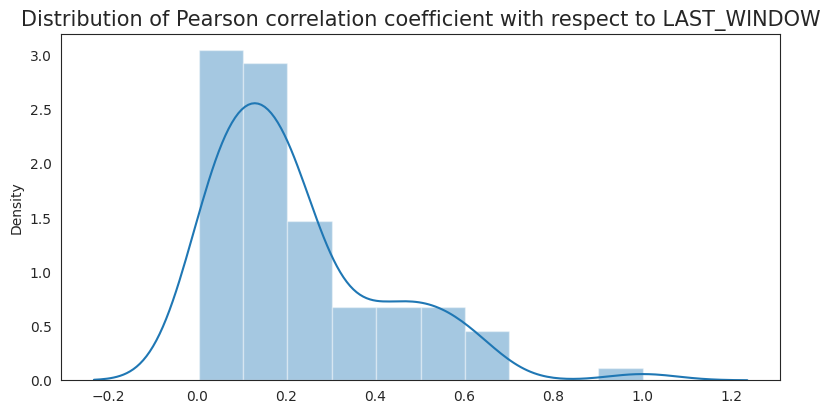

In [ ]:
#Define feature groups to investigate and compute pearson correlation
cols_to_investigate = np.unique([x for x in data_2.columns if x.split('_')[-1] in ('end', 'begin')])

data_2_corr = data_2[np.append(cols_to_investigate, 'LAST_WINDOW')].corr()['LAST_WINDOW']
data_2_corr = abs(data_2_corr)

plt.figure(figsize = (8,4))
sns.distplot(data_2_corr.values)
plt.tight_layout()
plt.title('Distribution of Pearson correlation coefficient with respect to LAST_WINDOW', fontsize = 15)


In [ ]:
#Select strongly LAST_WINDOW correlated features
data_2_corr = data_2_corr[(data_2_corr >= 0.5) & (data_2_corr < 1)]
data_2_corr.sort_values(ascending = False)

TEMPERATURE_DIFF_REL_end                0.632362
TEMPERATURE_DIFF_end                    0.629489
HEART_RATE_DIFF_REL_end                 0.626857
HEART_RATE_DIFF_end                     0.613473
BLOODPRESSURE_DIASTOLIC_DIFF_end        0.561317
RESPIRATORY_RATE_MIN_end                0.552837
TEMPERATURE_MIN_end                     0.538746
BLOODPRESSURE_SISTOLIC_DIFF_REL_end     0.535384
BLOODPRESSURE_SISTOLIC_DIFF_end         0.511842
BLOODPRESSURE_DIASTOLIC_DIFF_REL_end    0.509226
Name: LAST_WINDOW, dtype: float64

Text(0.5, 0.98, 'Investigating TEMPERATURE_DIFF_REL_end and BLOODPRESSURE_DIASTOLIC_DIFF_REL_end correlations')

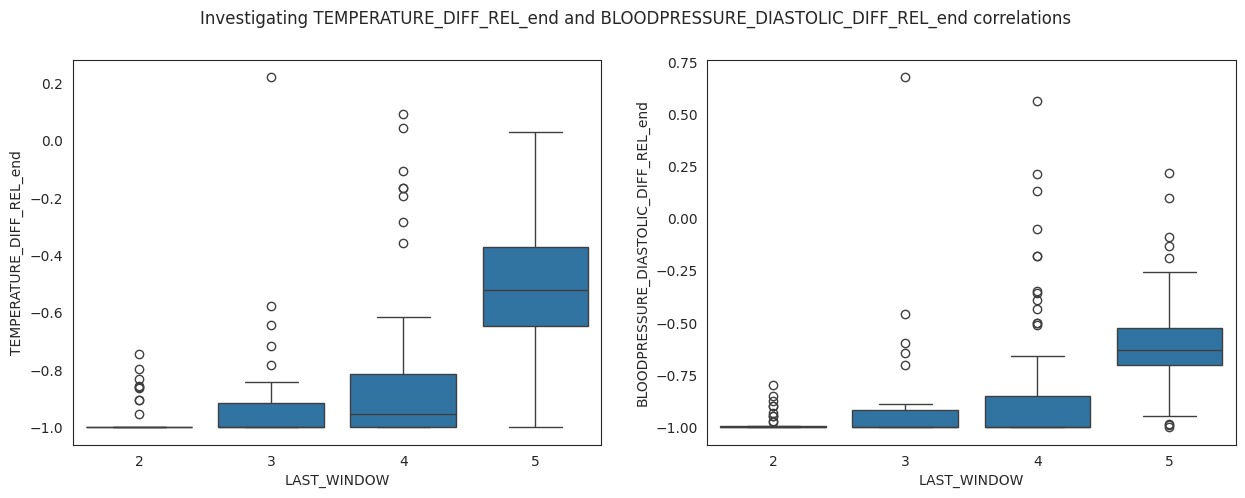

In [ ]:
#Plot TEMPERATURE_DIFF_REL_end, the one with the larger correlation coefficient
fig, axis = plt.subplots(1, 2, figsize = (15, 5))

sns.boxplot(x = 'LAST_WINDOW', y = 'TEMPERATURE_DIFF_REL_end', data = data_2, ax = axis[0])
sns.boxplot(x = 'LAST_WINDOW', y = 'BLOODPRESSURE_DIASTOLIC_DIFF_REL_end', data = data_2, ax = axis[1])


plt.suptitle('Investigating TEMPERATURE_DIFF_REL_end and BLOODPRESSURE_DIASTOLIC_DIFF_REL_end correlations')

In [ ]:
#Remove features strongly correlated to LAST_WINDOW
col_groups_to_remove = ['_'.join(x.split('_')[:-1]) for x in data_2_corr.index]
remaining_cols = [x for x in data_2.columns if '_'.join(x.split('_')[:-1]) not in col_groups_to_remove]

data_2 = data_2[remaining_cols]
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 1_begin,DISEASE GROUPING 2_begin,...,RESPIRATORY_RATE_MEDIAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.234568,-0.030928,-0.686486,-0.553846,-0.553846,-0.2625,0.0,0.0,...,-0.103448,-0.362319,-0.214286,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.382716,0.484536,-0.351351,-0.133333,-0.076923,-0.0125,0.0,0.0,...,-0.034483,-0.043478,0.178571,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.407407,-0.175258,-0.664865,-0.523077,-0.523077,-0.2375,0.0,0.0,...,-0.586207,-0.014493,0.214286,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.407407,-0.175258,-0.729730,-0.615385,-0.615385,-0.3125,0.0,0.0,...,-0.517241,0.188406,0.464286,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.382716,-0.154639,-0.729730,-0.615385,-0.615385,-0.3125,0.0,0.0,...,0.172414,-0.275362,-0.107143,-0.107143,1,90th,0,0.0,1,2


**Model 2.2 Correlations**

In [ ]:
#Rank feature correlations
data_2_corr = rank_correlation_score(data_2)
data_2_corr = data_2_corr[data_2_corr['Pearson_Corr'] < 1]
data_2_corr

,Feature_1,Feature_2,Pearson_Corr
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923
...,...,...,...
1528,OXYGEN_SATURATION_DIFF_begin,AGE_ABOVE65_1,0.000237
374,BLOODPRESSURE_SISTOLIC_MEAN_begin,DISEASE GROUPING 2_begin,0.000236
1509,OXYGEN_SATURATION_DIFF_begin,HEART_RATE_MEAN_end,0.000175
1967,RESPIRATORY_RATE_DIFF_begin,GENDER_1,0.000126


In [ ]:
data_2_corr[data_2_corr['Pearson_Corr'] >= 0.9]

,Feature_1,Feature_2,Pearson_Corr
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923
1925,RESPIRATORY_RATE_DIFF_begin,RESPIRATORY_RATE_DIFF_REL_begin,0.987618
2369,TEMPERATURE_MEAN_begin,TEMPERATURE_MEDIAN_begin,0.986740
3627,HEART_RATE_MEAN_end,HEART_RATE_MEDIAN_end,0.986183
75,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,0.985853
4074,OXYGEN_SATURATION_DIFF_REL_end,OXYGEN_SATURATION_MIN_end,0.985579


In [ ]:
data_2_corr['Feature_1_Type'] = [x.split('_')[-1] for x in data_2_corr['Feature_1']]
data_2_corr['Feature_2_Type'] = [x.split('_')[-1] for x in data_2_corr['Feature_2']]

time_corr = data_2_corr[data_2_corr['Pearson_Corr'] >= 0.9]
time_corr = time_corr[data_2_corr['Feature_1_Type'] != data_2_corr['Feature_2_Type']]

time_corr.drop(columns = ['Feature_1_Type', 'Feature_2_Type'])

,Feature_1,Feature_2,Pearson_Corr
1366,IMMUNOCOMPROMISED_begin,IMMUNOCOMPROMISED_end,0.966490
922,DISEASE GROUPING 5_begin,DISEASE GROUPING 5_end,0.956747
700,DISEASE GROUPING 2_begin,DISEASE GROUPING 2_end,0.933942
774,DISEASE GROUPING 3_begin,DISEASE GROUPING 3_end,0.932946


In [ ]:
print('Percentage of records in which DESEASE GROUPING 3 value does not change: %2.1f%%' \
    %(100*len(data_2[data_2['DISEASE GROUPING 3_begin'] == data_2['DISEASE GROUPING 3_end']]) / len(data_2)))

Percentage of records in which DESEASE GROUPING 3 value does not change: 98.8%


In [ ]:
#Define function to compute how the feature change relates to the target
def compute_likelyhood(data, col, target):
    begin_col = col + '_begin'
    end_col = col + '_end'

    change_data = data[data[begin_col] != data[end_col]]
    no_change_data = data[data[begin_col] == data[end_col]]

    change_likelyhood = len(change_data[change_data[target] == 1]) / len(change_data)
    no_change_likelyhood = len(no_change_data[no_change_data[target] == 1]) / len(no_change_data)

    print('Success probability on change: %2.1f%%' %(100 * change_likelyhood))
    print('Success probability on no change: %2.1f%%'%(100 * no_change_likelyhood))

In [ ]:
compute_likelyhood(data_2, 'DISEASE GROUPING 3', 'ICU')

Success probability on change: 0.0%
Success probability on no change: 42.4%


In [ ]:
data_2['DISEASE GROUPING 3_begin'].unique()

array([0., 1.])

In [ ]:
binary_feature_groups = np.unique(['_'.join(x.split('_')[:-1]) for x in data_2.columns.values
                                   if len(data_2[x].unique()) == 2], return_counts = True)
binary_feature_groups = [x for x,y  in zip(binary_feature_groups[0], binary_feature_groups[1]) if y > 1]

#Selected desired correlations
binary_feat_time_corr = data_2_corr[data_2_corr['Feature_1_Type'] != data_2_corr['Feature_2_Type']]
binary_feat_time_corr['Feature_1_Type'] = ['_'.join(x.split('_')[:-1])
                                           for x in binary_feat_time_corr['Feature_1']]
binary_feat_time_corr['Feature_2_Type'] = ['_'.join(x.split('_')[:-1])
                                           for x in binary_feat_time_corr['Feature_2']]

binary_feat_time_corr = binary_feat_time_corr[
    binary_feat_time_corr['Feature_1_Type'] == binary_feat_time_corr['Feature_2_Type']]
binary_feat_time_corr = binary_feat_time_corr[binary_feat_time_corr['Feature_1_Type'].isin(binary_feature_groups)]
binary_feat_time_corr

,Feature_1,Feature_2,Pearson_Corr,Feature_1_Type,Feature_2_Type
1366,IMMUNOCOMPROMISED_begin,IMMUNOCOMPROMISED_end,0.966490,IMMUNOCOMPROMISED,IMMUNOCOMPROMISED
922,DISEASE GROUPING 5_begin,DISEASE GROUPING 5_end,0.956747,DISEASE GROUPING 5,DISEASE GROUPING 5
700,DISEASE GROUPING 2_begin,DISEASE GROUPING 2_end,0.933942,DISEASE GROUPING 2,DISEASE GROUPING 2
774,DISEASE GROUPING 3_begin,DISEASE GROUPING 3_end,0.932946,DISEASE GROUPING 3,DISEASE GROUPING 3
996,DISEASE GROUPING 6_begin,DISEASE GROUPING 6_end,0.882772,DISEASE GROUPING 6,DISEASE GROUPING 6
626,DISEASE GROUPING 1_begin,DISEASE GROUPING 1_end,0.863576,DISEASE GROUPING 1,DISEASE GROUPING 1
1440,OTHER_begin,OTHER_end,0.323649,OTHER,OTHER


In [ ]:
#Remove '_begin' features for strongly time correlated group of attributes
data_2 = data_2.drop(columns =
                     binary_feat_time_corr[binary_feat_time_corr['Feature_1'] != 'OTHER_begin']['Feature_1'])
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 4_begin,HEART_RATE_MAX_begin,...,RESPIRATORY_RATE_MEDIAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,TEMPERATURE_MEDIAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.234568,-0.030928,-0.686486,-0.553846,-0.553846,-0.2625,0.0,-0.716418,...,-0.103448,-0.362319,-0.214286,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.382716,0.484536,-0.351351,-0.133333,-0.076923,-0.0125,0.0,-0.253731,...,-0.034483,-0.043478,0.178571,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.407407,-0.175258,-0.664865,-0.523077,-0.523077,-0.2375,0.0,-0.492537,...,-0.586207,-0.014493,0.214286,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.407407,-0.175258,-0.729730,-0.615385,-0.615385,-0.3125,1.0,-0.731343,...,-0.517241,0.188406,0.464286,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.382716,-0.154639,-0.729730,-0.615385,-0.615385,-0.3125,0.0,-0.313433,...,0.172414,-0.275362,-0.107143,-0.107143,1,90th,0,0.0,1,2


In [ ]:
#Select correlations for features in the same time level
single_time_step_corr = data_2_corr[data_2_corr['Feature_1_Type'] == data_2_corr['Feature_2_Type']]
single_time_step_corr = single_time_step_corr[single_time_step_corr['Pearson_Corr'] >= 0.9]
single_time_step_corr

,Feature_1,Feature_2,Pearson_Corr,Feature_1_Type,Feature_2_Type
1481,OXYGEN_SATURATION_DIFF_begin,OXYGEN_SATURATION_DIFF_REL_begin,0.999805,begin,begin
3997,OXYGEN_SATURATION_DIFF_end,OXYGEN_SATURATION_DIFF_REL_end,0.999786,end,end
1111,HEART_RATE_MEAN_begin,HEART_RATE_MEDIAN_begin,0.993496,begin,begin
371,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MEDIAN_begin,0.993123,begin,begin
4441,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_DIFF_REL_end,0.987923,end,end
1925,RESPIRATORY_RATE_DIFF_begin,RESPIRATORY_RATE_DIFF_REL_begin,0.987618,begin,begin
2369,TEMPERATURE_MEAN_begin,TEMPERATURE_MEDIAN_begin,0.986740,begin,begin
3627,HEART_RATE_MEAN_end,HEART_RATE_MEDIAN_end,0.986183,end,end
75,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MEDIAN_begin,0.985853,begin,begin
4074,OXYGEN_SATURATION_DIFF_REL_end,OXYGEN_SATURATION_MIN_end,0.985579,end,end


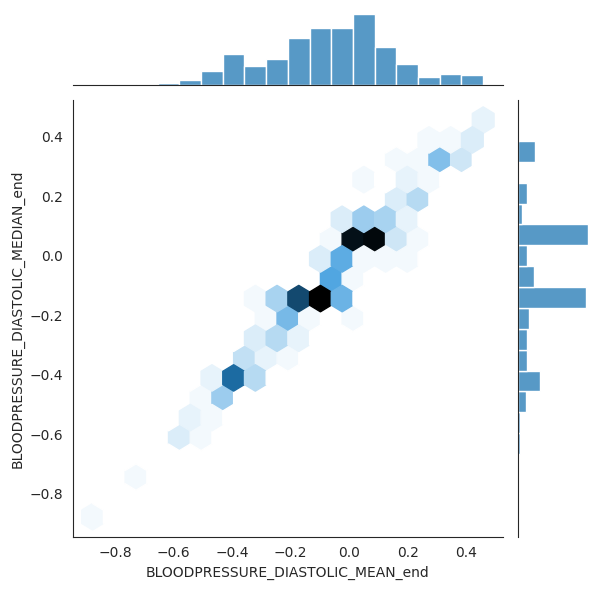

In [ ]:
#Plot BLOODPRESSURE_DIASTOLIC_MEAN_end vs. BLOODPRESSURE_DIASTOLIC_MEDIAN_end

sns.jointplot(x=data_2['BLOODPRESSURE_DIASTOLIC_MEAN_end'], y=data_2['BLOODPRESSURE_DIASTOLIC_MEDIAN_end'], kind='hex')
plt.show()

In [ ]:
#Remove correlated features
data_2 = data_2.drop(columns = single_time_step_corr['Feature_2'].values)
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,DISEASE GROUPING 4_begin,HEART_RATE_MAX_begin,HEART_RATE_MEAN_begin,HEART_RATE_MIN_begin,...,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.030928,-0.686486,-0.553846,-0.2625,0.0,-0.716418,-0.641509,-0.487179,...,-0.212121,-0.118644,-0.362319,-0.214286,1,60th,1,0.0,1,2
18,-0.008547,0.399177,0.484536,-0.351351,-0.133333,-0.0125,0.0,-0.253731,-0.295597,-0.282051,...,-0.151515,-0.186441,-0.043478,0.178571,0,20th,0,0.0,1,2
24,-0.589744,-0.407407,-0.175258,-0.664865,-0.523077,-0.2375,0.0,-0.492537,-0.358491,-0.230769,...,-0.636364,-0.593220,-0.014493,0.214286,1,80th,1,0.0,1,2
29,-0.589744,-0.407407,-0.175258,-0.729730,-0.615385,-0.3125,1.0,-0.731343,-0.660377,-0.504274,...,-0.575758,-0.525424,0.188406,0.464286,1,70th,0,1.0,1,2
31,-0.572650,-0.382716,-0.154639,-0.729730,-0.615385,-0.3125,0.0,-0.313433,-0.132075,-0.025641,...,0.030303,0.152542,-0.275362,-0.107143,1,90th,0,0.0,1,2


In [ ]:
#Encode remaining categorical feature
data_2 = encode_feature(data_2, 'AGE_PERCENTIL_1')

In [ ]:
#Split dataset into training and validation
feature_cols = data_2.drop(columns = ['ICU', 'LAST_WINDOW']).columns
x_train, x_validation, y_train, y_validation = train_test_split(data_2[feature_cols], data_2['ICU'],
                                                                test_size = 0.1,
                                                                shuffle = True)

CV model accuracy: 0.949 +/- 0.011
CV model roc_auc: 0.981 +/- 0.018
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.972


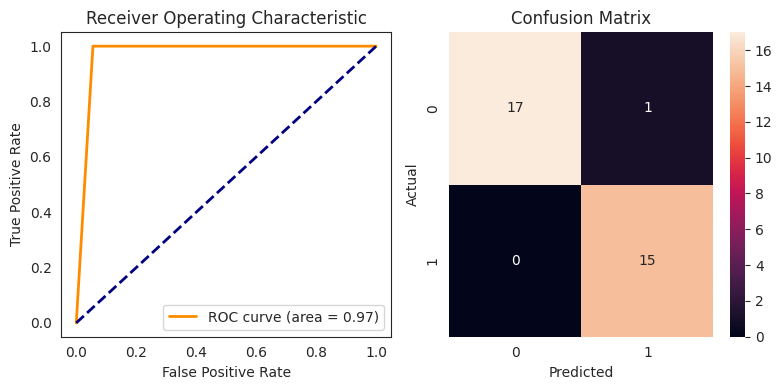

In [ ]:
#Cross-validate baseline model
baseline_model = RandomForestClassifier()
fitted_baseline_model = score_model(estimator = baseline_model,
                                    train_data = (x_train, y_train),
                                    validation_data = (x_validation, y_validation),
                                    cv = 5)

CV model accuracy: 0.873 +/- 0.013
CV model roc_auc: 0.933 +/- 0.018
Validation accuracy score: 0.939
Validation ROC_AUC score: 0.939


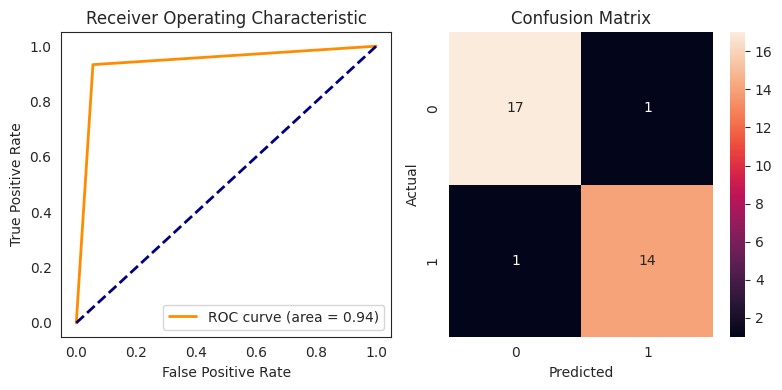

In [ ]:
logistic_model = LogisticRegression(random_state=10)
logistic_model = score_model(logistic_model, (x_train, y_train), (x_validation, y_validation), cv=5)

**3.4. Feature Selection**

<Axes: >

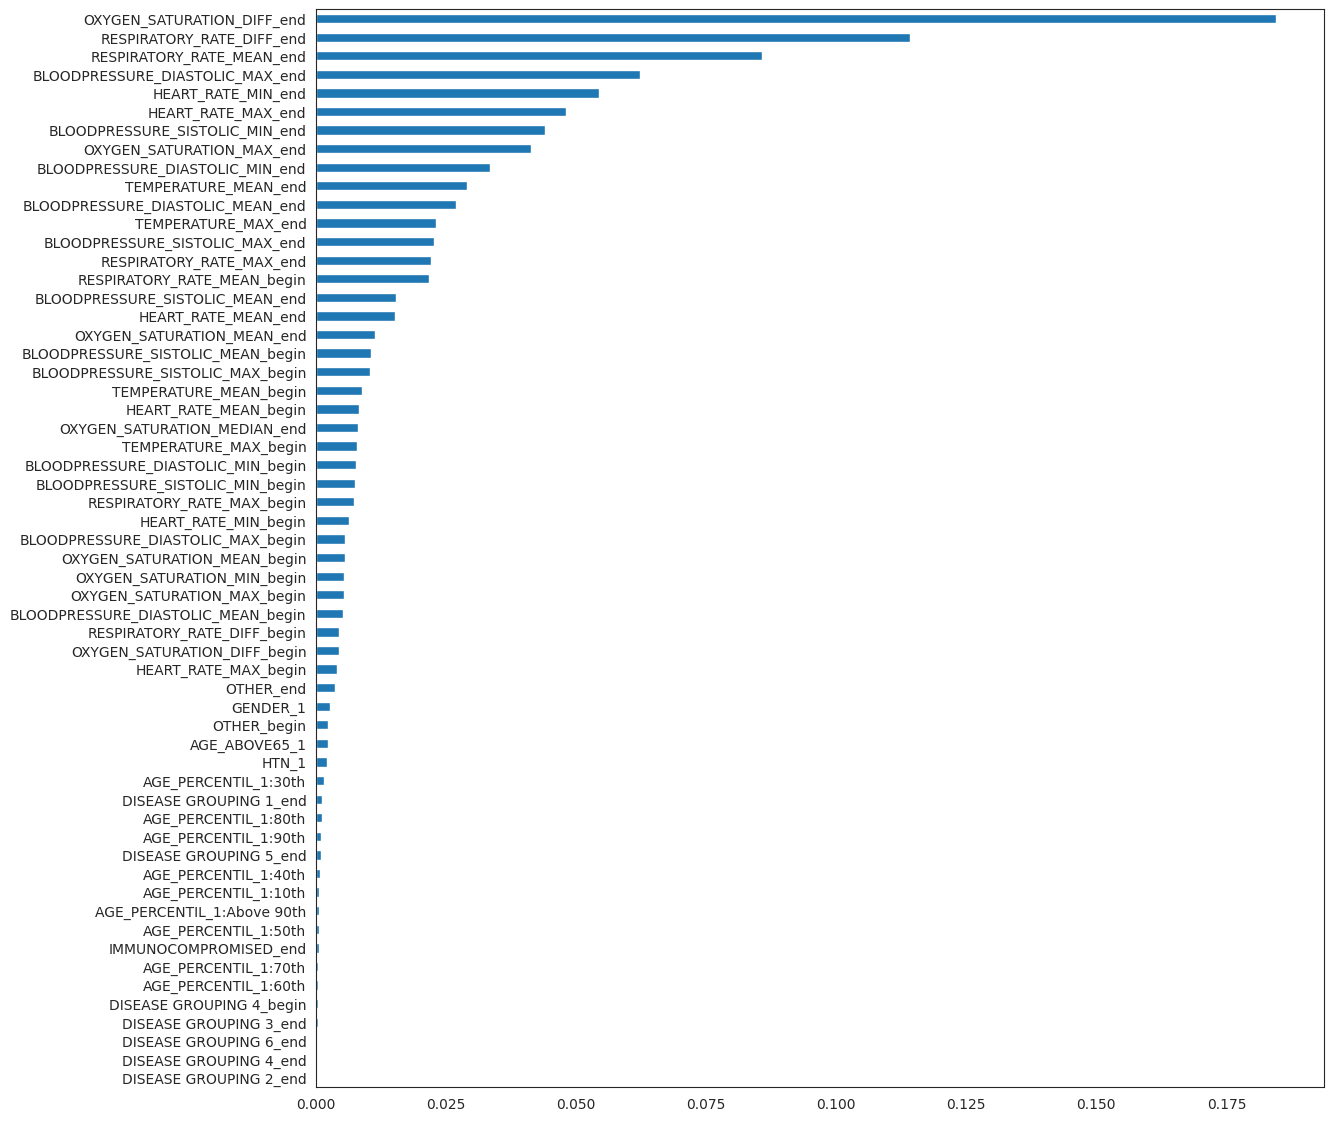

In [ ]:
#Plot feature importances for the Random Forest Model
feat_importances = pd.Series(data = fitted_baseline_model.feature_importances_,
                             index = feature_cols).sort_values()
feat_importances.plot(kind = 'barh', figsize = (13, 14))

CV model accuracy: 0.952 +/- 0.017
CV model roc_auc: 0.983 +/- 0.017
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.972


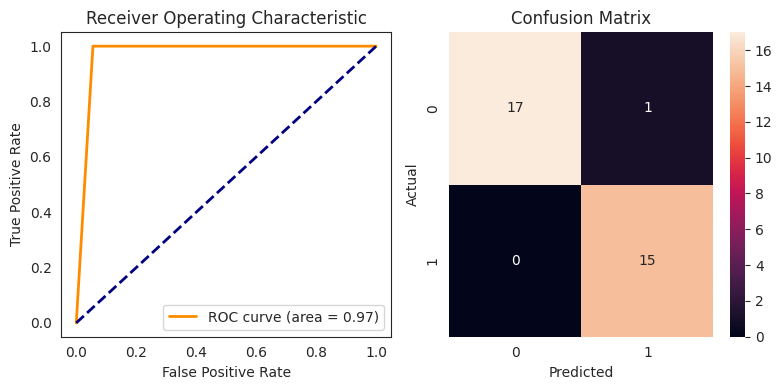

RandomForestClassifier()

In [ ]:
#Remove the 30% least important features
threhshold_index = int(len(feat_importances) * 0.7)
reduced_feature_cols = feat_importances.sort_values(ascending = False).index.values[:threhshold_index]

score_model(estimator = RandomForestClassifier(),
            train_data = (x_train[reduced_feature_cols], y_train),
            validation_data = (x_validation[reduced_feature_cols], y_validation),
            cv = 5)

In [ ]:
#Remove least important features
not_important_cols = [x for x in feature_cols if x not in reduced_feature_cols]
data_2 = data_2.drop(columns = not_important_cols)
data_2.head()

,BLOODPRESSURE_DIASTOLIC_MAX_begin,BLOODPRESSURE_DIASTOLIC_MEAN_begin,BLOODPRESSURE_DIASTOLIC_MIN_begin,BLOODPRESSURE_SISTOLIC_MAX_begin,BLOODPRESSURE_SISTOLIC_MEAN_begin,BLOODPRESSURE_SISTOLIC_MIN_begin,HEART_RATE_MAX_begin,HEART_RATE_MEAN_begin,HEART_RATE_MIN_begin,OTHER_begin,...,OXYGEN_SATURATION_MEDIAN_end,RESPIRATORY_RATE_DIFF_end,RESPIRATORY_RATE_MAX_end,RESPIRATORY_RATE_MEAN_end,TEMPERATURE_MAX_end,TEMPERATURE_MEAN_end,AGE_ABOVE65_1,GENDER_1,ICU,LAST_WINDOW
14,-0.470085,-0.234568,-0.030928,-0.686486,-0.553846,-0.2625,-0.716418,-0.641509,-0.487179,1.0,...,0.736842,-1.000000,-0.212121,-0.118644,-0.362319,-0.214286,1,1,1,2
18,-0.008547,0.399177,0.484536,-0.351351,-0.133333,-0.0125,-0.253731,-0.295597,-0.282051,0.0,...,0.842105,-0.647059,-0.151515,-0.186441,-0.043478,0.178571,0,0,1,2
24,-0.589744,-0.407407,-0.175258,-0.664865,-0.523077,-0.2375,-0.492537,-0.358491,-0.230769,1.0,...,0.684211,-1.000000,-0.636364,-0.593220,-0.014493,0.214286,1,1,1,2
29,-0.589744,-0.407407,-0.175258,-0.729730,-0.615385,-0.3125,-0.731343,-0.660377,-0.504274,1.0,...,0.736842,-1.000000,-0.575758,-0.525424,0.188406,0.464286,1,0,1,2
31,-0.572650,-0.382716,-0.154639,-0.729730,-0.615385,-0.3125,-0.313433,-0.132075,-0.025641,1.0,...,0.842105,-1.000000,0.030303,0.152542,-0.275362,-0.107143,1,0,1,2


CV model accuracy: 0.935 +/- 0.033
CV model roc_auc: 0.981 +/- 0.018
Validation accuracy score: 0.970
Validation ROC_AUC score: 0.972


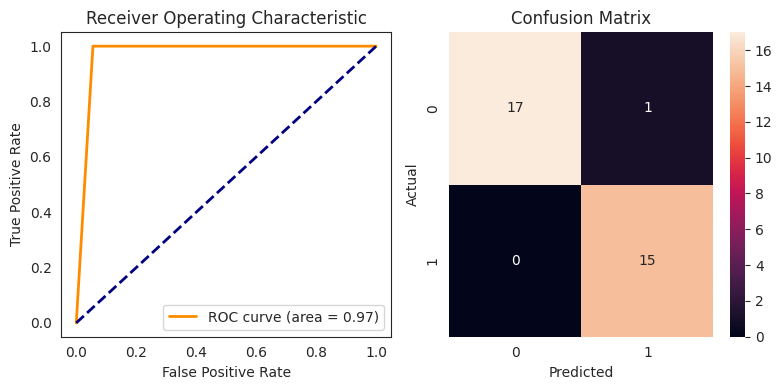

In [ ]:
#Retrain model for reduced dataset
feature_cols = [x for x in feature_cols if x in data_2.columns.values]

x_train, x_validation, y_train, y_validation = train_test_split(data_2[feature_cols], data_2['ICU'],
                                                                test_size = 0.1,
                                                                shuffle = True)

model_2 = score_model(estimator = RandomForestClassifier(),
                      train_data = (x_train, y_train),
                      validation_data = (x_validation, y_validation),
                      cv = 5)

In [ ]:
pip install aif360

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [ ]:
aif_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [ ]:
aif_data.dropna(axis=0, inplace=True)

# **4. AIF360**

In [ ]:
!pip install Pipeline_LabelEncoder-0.1.zip
!pip install aif360
!pip install fairlearn

Processing ./Pipeline_LabelEncoder-0.1.zip
  Preparing metadata (setup.py) ... done
  Created wheel for Pipeline-LabelEncoder: filename=Pipeline_LabelEncoder-0.1-py3-none-any.whl size=2034 sha256=beebf9167102dfc2e32631a2440e56d88d238b962817129cc4227d969b476f1d
  Stored in directory: /root/.cache/pip/wheels/99/b9/37/ed62b7c823e36e57a553f409c6e8c78c4bf55b042e8ab05c8c
Successfully built Pipeline-LabelEncoder
  Attempting uninstall: Pipeline-LabelEncoder
    Found existing installation: Pipeline-LabelEncoder 0.1
    Uninstalling Pipeline-LabelEncoder-0.1:
      Successfully uninstalled Pipeline-LabelEncoder-0.1


**4.1. Pre-Processing**
demonstrates how to remove the bias during "Pre-processing stage" using AI 360 fairness toolkit by adjusting the weights

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.__version__

'2.15.0'

In [ ]:
pip install 'aif360[LawSchoolGPA]'

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

In [ ]:
aif_data.describe(include = 'all')

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
count,545.00000,545.000000,545,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.00000,...,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545,545.000000
unique,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,10th,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABOVE_12,NaN
freq,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374,NaN
mean,192.53578,0.471560,NaN,0.363303,0.137615,0.042202,0.122936,0.025688,0.144954,0.06422,...,-0.545435,-0.771317,-0.575193,-0.433444,-0.629969,-0.455022,-0.546926,-0.771046,NaN,0.484404
std,111.95408,0.499649,NaN,0.481393,0.344812,0.201234,0.328665,0.158348,0.352378,0.24537,...,0.354024,0.410707,0.380358,0.478718,0.307775,0.529002,0.352455,0.411122,NaN,0.500216
min,0.00000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,0.000000
25%,94.00000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-0.880952,-0.979798,-0.906832,-0.862349,-0.931885,-0.940715,-0.884926,-0.979921,NaN,0.000000
50%,194.00000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-0.523810,-0.878788,-0.612422,-0.485092,-0.634847,-0.670968,-0.535361,-0.878893,NaN,0.000000
75%,288.00000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,-0.309524,-0.797980,-0.403727,-0.186211,-0.462377,-0.018676,-0.311426,-0.798155,NaN,1.000000


In [ ]:
privileged_groups = [{'GENDER': 1}]
unprivileged_groups = [{'GENDER': 0}]
cost_constraint='weighted'
favorable_label = 1
unfavorable_label = 0

In [ ]:
from sklearn import preprocessing
categorical_column = ['WINDOW','AGE_PERCENTIL']

data_encoded = aif_data.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical_column:
        data_encoded[col] = lab_enc.fit_transform(aif_data[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)

data_encoded.head()

Feature WINDOW
mapping {'0-2': 0, '2-4': 1, '4-6': 2, '6-12': 3, 'ABOVE_12': 4}
Feature AGE_PERCENTIL
mapping {'10th': 0, '20th': 1, '30th': 2, '40th': 3, '50th': 4, '60th': 5, '70th': 6, '80th': 7, '90th': 8, 'Above 90th': 9}


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
4,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,4,1
6,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,1
8,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,3,1
9,1,1,8,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,4,1
14,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,4,1


In [ ]:
from Pipeline_LabelEncoder.sklearn_label_encoder import PipelineLabelEncoder
preprocessed_data = PipelineLabelEncoder(columns = ['WINDOW','AGE_PERCENTIL']).fit_transform(data_encoded)
print('-------------------------')

Inside fit transform
Feature WINDOW
mapping {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Feature AGE_PERCENTIL
mapping {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
-------------------------


In [ ]:
#Create binary label dataset that can be used by bias mitigation algorithms
ICU_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=preprocessed_data,
                                label_names=['ICU'],
                                protected_attribute_names=['GENDER', 'AGE_ABOVE65'],
                                unprivileged_protected_attributes=unprivileged_groups)

In [ ]:
display(Markdown("#### Training Data Details"))
print("shape of the training dataset", ICU_dataset.features.shape)
print("Training data favorable label", ICU_dataset.favorable_label)
print("Training data unfavorable label", ICU_dataset.unfavorable_label)
print("Training data protected attribute", ICU_dataset.protected_attribute_names)
print("Training data privileged protected attribute (1:Male and 0:Female)",
      ICU_dataset.privileged_protected_attributes)
print("Training data unprivileged protected attribute (1:Male and 0:Female)",
      ICU_dataset.unprivileged_protected_attributes)

#### Training Data Details

shape of the training dataset (545, 230)
Training data favorable label 1.0
Training data unfavorable label 0.0
Training data protected attribute ['GENDER', 'AGE_ABOVE65']
Training data privileged protected attribute (1:Male and 0:Female) [array([1.]), array([1.])]
Training data unprivileged protected attribute (1:Male and 0:Female) [array([0.]), array([0.])]


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(ICU_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" %
      metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.118287


We can observe that, priviledged group had **11%** more chance of getting a favorable outcome because of the bias in the dataset.

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(ICU_dataset)
train_tf_dataset = RW.transform(ICU_dataset)

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(train_tf_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f"
      % metric_orig_train.mean_difference())

We can observe that, after applying bias mitigation algorithm, there is no unfair advantage between priviledged & unpriviledged groups.

**4.2. In-Process**

In [ ]:
ICU_dataset_train, ICU_dataset_test = ICU_dataset.split([0.9], shuffle=True)

In [ ]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(ICU_dataset_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(ICU_dataset_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.100217
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.273392


In [ ]:
min_max_scaler = MaxAbsScaler()
ICU_dataset_train.features = min_max_scaler.fit_transform(ICU_dataset_train.features)
ICU_dataset_test.features = min_max_scaler.transform(ICU_dataset_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(ICU_dataset_train,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(ICU_dataset_test,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.100217
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.273392


**Build plan classifier without debiasing**

In [ ]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False

sess = tf.compat.v1.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [ ]:
plain_model.fit(ICU_dataset_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.785064
epoch 1; iter: 0; batch classifier loss: 0.634136
epoch 2; iter: 0; batch classifier loss: 0.557838
epoch 3; iter: 0; batch classifier loss: 0.515039
epoch 4; iter: 0; batch classifier loss: 0.517679
epoch 5; iter: 0; batch classifier loss: 0.457211
epoch 6; iter: 0; batch classifier loss: 0.436751
epoch 7; iter: 0; batch classifier loss: 0.406313
epoch 8; iter: 0; batch classifier loss: 0.395479
epoch 9; iter: 0; batch classifier loss: 0.439850
epoch 10; iter: 0; batch classifier loss: 0.384102
epoch 11; iter: 0; batch classifier loss: 0.451860
epoch 12; iter: 0; batch classifier loss: 0.359409
epoch 13; iter: 0; batch classifier loss: 0.340924
epoch 14; iter: 0; batch classifier loss: 0.459637
epoch 15; iter: 0; batch classifier loss: 0.397248
epoch 16; iter: 0; batch classifier loss: 0.384983
epoch 17; iter: 0; batch classifier loss: 0.383750
epoch 18; iter: 0; batch classifier loss: 0.392596
epoch 19; iter: 0; batch classifier loss:

In [ ]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(ICU_dataset_train)
dataset_nodebiasing_test = plain_model.predict(ICU_dataset_test)

**Metrics for the dataset from plain model (without debiasing)**

In [ ]:
display(Markdown("#### Model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(ICU_dataset_test,
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.110385
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.242690


#### Model - without debiasing - classification metrics

Test set: Classification accuracy = 0.854545
Test set: Balanced classification accuracy = 0.863636
Test set: Disparate impact = 1.658730
Test set: Equal opportunity difference = 0.090000
Test set: Average odds difference = 0.045000
Test set: Theil_index = 0.129872


**Apply in-processing algorithm based on adversarial learning**

In [ ]:
sess.close()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()

In [ ]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [ ]:
debiased_model.fit(ICU_dataset_train)

epoch 0; iter: 0; batch classifier loss: 0.732432; batch adversarial loss: 0.694465
epoch 1; iter: 0; batch classifier loss: 0.607993; batch adversarial loss: 0.691037
epoch 2; iter: 0; batch classifier loss: 0.624816; batch adversarial loss: 0.671705
epoch 3; iter: 0; batch classifier loss: 0.656092; batch adversarial loss: 0.669115
epoch 4; iter: 0; batch classifier loss: 0.514001; batch adversarial loss: 0.661213
epoch 5; iter: 0; batch classifier loss: 0.524104; batch adversarial loss: 0.672972
epoch 6; iter: 0; batch classifier loss: 0.491470; batch adversarial loss: 0.700868
epoch 7; iter: 0; batch classifier loss: 0.477016; batch adversarial loss: 0.668496
epoch 8; iter: 0; batch classifier loss: 0.560148; batch adversarial loss: 0.665225
epoch 9; iter: 0; batch classifier loss: 0.481005; batch adversarial loss: 0.654575
epoch 10; iter: 0; batch classifier loss: 0.403150; batch adversarial loss: 0.677668
epoch 11; iter: 0; batch classifier loss: 0.401892; batch adversarial loss:

In [ ]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(ICU_dataset_train)
dataset_debiasing_test = debiased_model.predict(ICU_dataset_test)

In [ ]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(ICU_dataset_test,
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.110385
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.242690


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.069949
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.267544


#### Model - without debiasing - classification metrics

Test set: Classification accuracy = 0.854545
Test set: Balanced classification accuracy = 0.863636
Test set: Disparate impact = 1.658730
Test set: Equal opportunity difference = 0.090000
Test set: Average odds difference = 0.045000
Test set: Theil_index = 0.129872


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.854545
Test set: Balanced classification accuracy = 0.871212
Test set: Disparate impact = 1.847222
Test set: Equal opportunity difference = 0.215000
Test set: Average odds difference = 0.062045
Test set: Theil_index = 0.143805


**4.3. Post-Processing**

In [ ]:
dataset_orig_train, dataset_orig_vt = ICU_dataset.split([0.6], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [ ]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Dataset shape

(327, 230)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['GENDER', 'AGE_ABOVE65']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATI

Metric for the original datasets (without any classifiers)

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.093018


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.187215


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.137413


Train classifier (logistic regression on original training data)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred

y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

Results before post-processing

In [ ]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.04623674014978807
Difference in GFNR between unprivileged and privileged groups
0.020885542854710296


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
0.002581979071346413
Difference in GFNR between unprivileged and privileged groups
-0.0773890600511548


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.0015224768231892616
Difference in GFNR between unprivileged and privileged groups
-0.07261558170719264


Perform odds equalizing post processing on scores

In [ ]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=None)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

Transform validation and test data using the post processing algorithm

In [ ]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

Results after post-processing

In [ ]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
0.09890570405971802
Difference in GFNR between unprivileged and privileged groups
-0.036187770261473906


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
0.0015224768231892616
Difference in GFNR between unprivileged and privileged groups
-0.027152979811558703


Testing: Check if the rates for validation data has gone down after transformation

In [ ]:
print(np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)))
print(np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)))

0.0773890600511548
0.036187770261473906


In [ ]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):

    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)

    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp

    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid,
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:01<00:00, 19.88it/s]


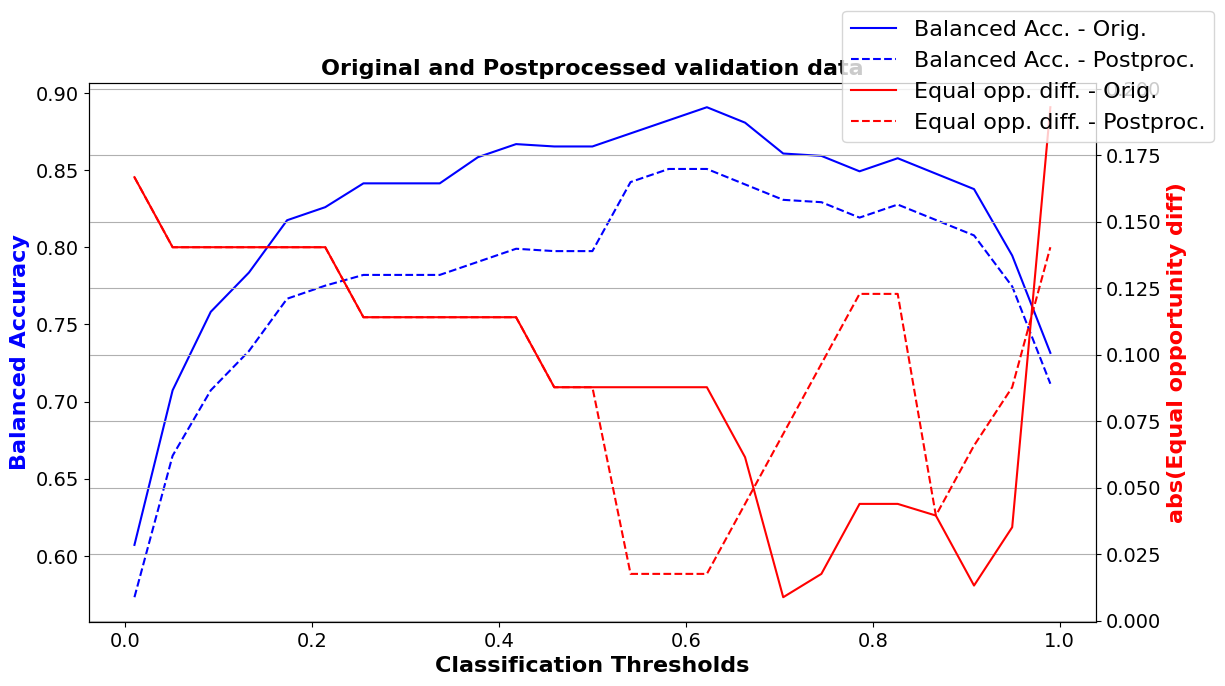

In [ ]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",],
           fontsize=16)

We can observe that, after applying bias mitigation algorithm on predicted labels, there's a change in balanced accuracy and equal opportunity difference indicating the fairness of the results.